<a href="https://colab.research.google.com/github/imviswa4u/MScFE_Capstone_1158/blob/Module-7-Draft/Capstone_final_draft1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1 - Importing relevant libraries

* Arch module provides major tools for financial econometrics.
* Quandl is a platform for financial and economic data. We install quandl package to use Quandl API in Python.
* FredApi is an Api provided by FRED and fredapi library is a Python wrapper for the FredApi. We install fredapi package to use FredAPI (FRED Data) if Quandl fails.
* Yfinance compared to Quandle and FredApi provides a limited number of IR instruments. YF is left in the code to provide data in case any other data source fails.

In [1]:
pip install arch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 KB 11.3 MB/s eta 0:00:00


In [2]:
pip install quandl --quiet

In [3]:
pip install fredapi --quiet

In [4]:
pip install yfinance --quiet

In [5]:
!pip install --upgrade pandas --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 73.4 MB/s eta 0:00:00


In [6]:
!pip install --upgrade pandas-datareader --quiet

In [7]:
!pip install heatmapz &> /dev/null --quiet

In [8]:
!pip install PyPortfolioOpt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 KB 2.2 MB/s eta 0:00:00


In [9]:
! pip install -U git+https://github.com/emoen/Machine-Learning-for-Asset-Managers --quiet #denoising link

  Preparing metadata (setup.py) ... done


In [10]:
#libs to work with data, formulas and graphs
import pandas as pd
from pandas_datareader import data as web
import numpy as np
import scipy as sp
import datetime
from datetime import datetime

#lib to work with graphs
import matplotlib as mpl
from matplotlib import pyplot as plt
from heatmap import heatmap, corrplot
from pypfopt import plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#lib to get financial data 
import yfinance as yf
yf.pdr_override()
import quandl
from fredapi import Fred

#lib to work stats tools
import sklearn
from sklearn.preprocessing import Normalizer
import seaborn as sns
import statsmodels.api as sm
import scipy as sp
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.optimize import Bounds
from scipy.optimize import minimize
from Machine_Learning_for_Asset_Managers import ch2_marcenko_pastur_pdf as c #denoising
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans #k-means
from sklearn.decomposition import PCA as PCA
from sklearn.preprocessing import scale

#tests
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.tsa.stattools import kpss
from arch.unitroot import PhillipsPerron as pp

#technical
import warnings
warnings.filterwarnings("ignore")
import sys

# QUANDL API Key
quandl.ApiConfig.api_key = "45xv1xG1X3aWTLZ1oRcp"

# FRED API key
fred_key = "02e42817b0bcd1d7e7ee373eea6365c0"
fred = Fred(api_key=fred_key)

## Step 2 - Preparing datasets

The study covers Swap rates, US daily Treasury yield curve rates and spreads of different maturities.

The IR Swaps, Treasuries and spread data was uploaded from the Federal Reserve official web site [FRED DATA ](https://https://fred.stlouisfed.org/series/INTDSRUSM193N) with the use of two Fred Data Api Python wrappers Quandle and Fredapi. The rates data used in the research is freely available to registered users. 


### Importing Swap rates data

In [11]:
swap_names = ['FRED/DSWP1', 
             'FRED/DSWP2', 
             'FRED/DSWP3', 
             'FRED/DSWP4', 
             'FRED/DSWP5', 
             'FRED/DSWP7', 
             'FRED/DSWP10', 
             'FRED/DSWP30']

swap_df = quandl.get(swap_names)
swap_df = swap_df.dropna()
swap_df.columns = ["SWAP1",
                  "SWAP2",
                  "SWAP3",
                  "SWAP4",
                  "SWAP5",
                  "SWAP7",
                  "SWAP10",
                  "SWAP30"]

cols = ["SWAP1",
        "SWAP2",
        "SWAP3",
        "SWAP5",
        "SWAP7",
        "SWAP10"]


In [12]:
swap_df.head(2)

SWAP1  SWAP2  SWAP3  SWAP4  SWAP5  SWAP7  SWAP10  SWAP30
DATE                                                                
2000-07-03   7.10   7.16   7.17   7.17   7.17   7.20    7.24    7.24
2000-07-05   7.03   7.06   7.07   7.07   7.08   7.11    7.14    7.16

In [13]:
swap_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4078 entries, 2000-07-03 to 2016-10-28
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SWAP1   4078 non-null   float64
 1   SWAP2   4078 non-null   float64
 2   SWAP3   4078 non-null   float64
 3   SWAP4   4078 non-null   float64
 4   SWAP5   4078 non-null   float64
 5   SWAP7   4078 non-null   float64
 6   SWAP10  4078 non-null   float64
 7   SWAP30  4078 non-null   float64
dtypes: float64(8)
memory usage: 286.7 KB


### Importing Treasury rates data

In [14]:
treasury = ['FRED/DGS1MO',
           'FRED/DGS3MO',
           'FRED/DGS6MO',
           'FRED/DGS1',
           'FRED/DGS2',
           'FRED/DGS3',
           'FRED/DGS5',
           'FRED/DGS7',
           'FRED/DGS10',
           'FRED/DGS20',
           'FRED/DGS30']

treasury_df = quandl.get(treasury)
treasury_df.columns = ['TRESY1mo',
                    'TRESY3mo', 
                    'TRESY6mo',
                    'TRESY1y',
                    'TRESY2y',
                    'TRESY3y',
                    'TRESY5y',
                    'TRESY7y',
                    'TRESY10y',
                    'TRESY20y',
                    'TRESY30y']

col = ['TRESY1y',
                    'TRESY2y',
                    'TRESY3y',
                    'TRESY5y',
                    'TRESY7y',
                    'TRESY10y']

In [15]:
treasury_df.head(2)

TRESY1mo  TRESY3mo  TRESY6mo  TRESY1y  TRESY2y  TRESY3y  TRESY5y  \
Date                                                                           
1962-01-02       NaN       NaN       NaN     3.22      NaN      3.7     3.88   
1962-01-03       NaN       NaN       NaN     3.24      NaN      3.7     3.87   

            TRESY7y  TRESY10y  TRESY20y  TRESY30y  
Date                                               
1962-01-02      NaN      4.06      4.07       NaN  
1962-01-03      NaN      4.03      4.07       NaN

In [16]:
treasury_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15120 entries, 1962-01-02 to 2022-07-15
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TRESY1mo  5242 non-null   float64
 1   TRESY3mo  10218 non-null  float64
 2   TRESY6mo  10218 non-null  float64
 3   TRESY1y   15120 non-null  float64
 4   TRESY2y   11528 non-null  float64
 5   TRESY3y   15120 non-null  float64
 6   TRESY5y   15120 non-null  float64
 7   TRESY7y   13250 non-null  float64
 8   TRESY10y  15120 non-null  float64
 9   TRESY20y  13431 non-null  float64
 10  TRESY30y  11350 non-null  float64
dtypes: float64(11)
memory usage: 1.4 MB


### Building rates Spread rates data

Selected IR instruments are considered for a wide range of maturities however terms less than one year were excluded as no swaps data was available for less than one year-maturities. The IR Swap Rates data is available for a period 2000-07-03 to 2016-10-28. The Federal Reserve Board has discontinued this series as of October 31, 2016. Treasury yields are available from 1962-01-02 till present. 

The Swap – Treasury spreads for different maturities were constructed based on imported rates: 
**Spread_i  = Swap rate_i  – Treasury rate_i,** i-maturity. 

The resulting data set is limited with an interval for Swap rates data a period 2000-07-03 to 2016-10-28 which encounters 4078 observations of each rate.


In [17]:
swap_df2 = swap_df.copy()
swap_df2 = swap_df2.loc[:, ]

In [18]:
treasury_df_ = treasury_df.loc[:, col]
treasury_df_ = treasury_df_.dropna()

In [19]:
combined_df = treasury_df_.merge(swap_df2, left_index=True, right_index=True)

In [20]:
combined_df.head(2)

TRESY1y  TRESY2y  TRESY3y  TRESY5y  TRESY7y  TRESY10y  SWAP1  \
2000-07-03     6.07     6.31     6.24     6.12     6.19      6.00   7.10   
2000-07-05     6.06     6.29     6.23     6.12     6.18      5.99   7.03   

            SWAP2  SWAP3  SWAP4  SWAP5  SWAP7  SWAP10  SWAP30  
2000-07-03   7.16   7.17   7.17   7.17   7.20    7.24    7.24  
2000-07-05   7.06   7.07   7.07   7.08   7.11    7.14    7.16

In [21]:
combined_df.info(2)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4078 entries, 2000-07-03 to 2016-10-28
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TRESY1y   4078 non-null   float64
 1   TRESY2y   4078 non-null   float64
 2   TRESY3y   4078 non-null   float64
 3   TRESY5y   4078 non-null   float64
 4   TRESY7y   4078 non-null   float64
 5   TRESY10y  4078 non-null   float64
 6   SWAP1     4078 non-null   float64
 7   SWAP2     4078 non-null   float64
 8   SWAP3     4078 non-null   float64
 9   SWAP4     4078 non-null   float64
 10  SWAP5     4078 non-null   float64
 11  SWAP7     4078 non-null   float64
 12  SWAP10    4078 non-null   float64
 13  SWAP30    4078 non-null   float64
dtypes: float64(14)
memory usage: 477.9 KB


In [22]:
spread = [combined_df.SWAP1-combined_df.TRESY1y, 
        combined_df.SWAP2-combined_df.TRESY2y,
       combined_df.SWAP3-combined_df.TRESY3y,
       combined_df.SWAP5-combined_df.TRESY5y,
       combined_df.SWAP7-combined_df.TRESY7y,
       combined_df.SWAP10-combined_df.TRESY10y]
spread_df = pd.DataFrame(np.array(spread).T, index=combined_df.index, 
                         columns = ["SPREAD1y", "SPREAD2y", "SPREAD3y", "SPREAD5y", "SPREAD7y", "SPREAD10y"])

In [23]:
spread_df.head(2)

SPREAD1y  SPREAD2y  SPREAD3y  SPREAD5y  SPREAD7y  SPREAD10y
2000-07-03      1.03      0.85      0.93      1.05      1.01       1.24
2000-07-05      0.97      0.77      0.84      0.96      0.93       1.15

In [24]:
spread_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4078 entries, 2000-07-03 to 2016-10-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SPREAD1y   4078 non-null   float64
 1   SPREAD2y   4078 non-null   float64
 2   SPREAD3y   4078 non-null   float64
 3   SPREAD5y   4078 non-null   float64
 4   SPREAD7y   4078 non-null   float64
 5   SPREAD10y  4078 non-null   float64
dtypes: float64(6)
memory usage: 223.0 KB


### Importing market indicators

In [25]:
corps = [ ('S&P 500',  '^GSPC'), ('CBOE Volatility Index', '^VIX')]
tickers = ["^VIX", "^GSPC"]

In [26]:
#Import close prices from Yahoo!finance
prices_close = pd.DataFrame()
for i in tickers:
    prices_close[i] = yf.download(i,'2000-01-01','2023-01-01')['Adj Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [27]:
prices_close.head(2)

^VIX        ^GSPC
Date                              
2000-01-03  24.209999  1455.219971
2000-01-04  27.010000  1399.420044

In [28]:
combined_df2 = combined_df.merge(prices_close, left_index=True, right_index=True)


In [29]:
combined_df2.head(2)

TRESY1y  TRESY2y  TRESY3y  TRESY5y  TRESY7y  TRESY10y  SWAP1  \
2000-07-03     6.07     6.31     6.24     6.12     6.19      6.00   7.10   
2000-07-05     6.06     6.29     6.23     6.12     6.18      5.99   7.03   

            SWAP2  SWAP3  SWAP4  SWAP5  SWAP7  SWAP10  SWAP30   ^VIX  \
2000-07-03   7.16   7.17   7.17   7.17   7.20    7.24    7.24  19.83   
2000-07-05   7.06   7.07   7.07   7.08   7.11    7.14    7.16  21.16   

                  ^GSPC  
2000-07-03  1469.540039  
2000-07-05  1446.229980

In [30]:
combined_df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4072 entries, 2000-07-03 to 2016-10-28
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TRESY1y   4072 non-null   float64
 1   TRESY2y   4072 non-null   float64
 2   TRESY3y   4072 non-null   float64
 3   TRESY5y   4072 non-null   float64
 4   TRESY7y   4072 non-null   float64
 5   TRESY10y  4072 non-null   float64
 6   SWAP1     4072 non-null   float64
 7   SWAP2     4072 non-null   float64
 8   SWAP3     4072 non-null   float64
 9   SWAP4     4072 non-null   float64
 10  SWAP5     4072 non-null   float64
 11  SWAP7     4072 non-null   float64
 12  SWAP10    4072 non-null   float64
 13  SWAP30    4072 non-null   float64
 14  ^VIX      4072 non-null   float64
 15  ^GSPC     4072 non-null   float64
dtypes: float64(16)
memory usage: 540.8 KB


## Step 2* Alternative Data source

The reserch is based on data imported from Quandl. FRED can be used as an alternative to Quandle. 

In [31]:
startDate = '2000-01-01'
endDate = '2023-01-01'
df = []
ids = ['DGS{}'.format(i) for i in ['1MO', '3MO', '6MO', 1,2,5,7,10,20,30]]
for s in ids:
    df.append(fred.get_series(s, observation_start=startDate, observation_end=endDate)/100)
  
df = pd.concat(df,axis=1)
df.columns = ids
maturity_df = df.dropna()

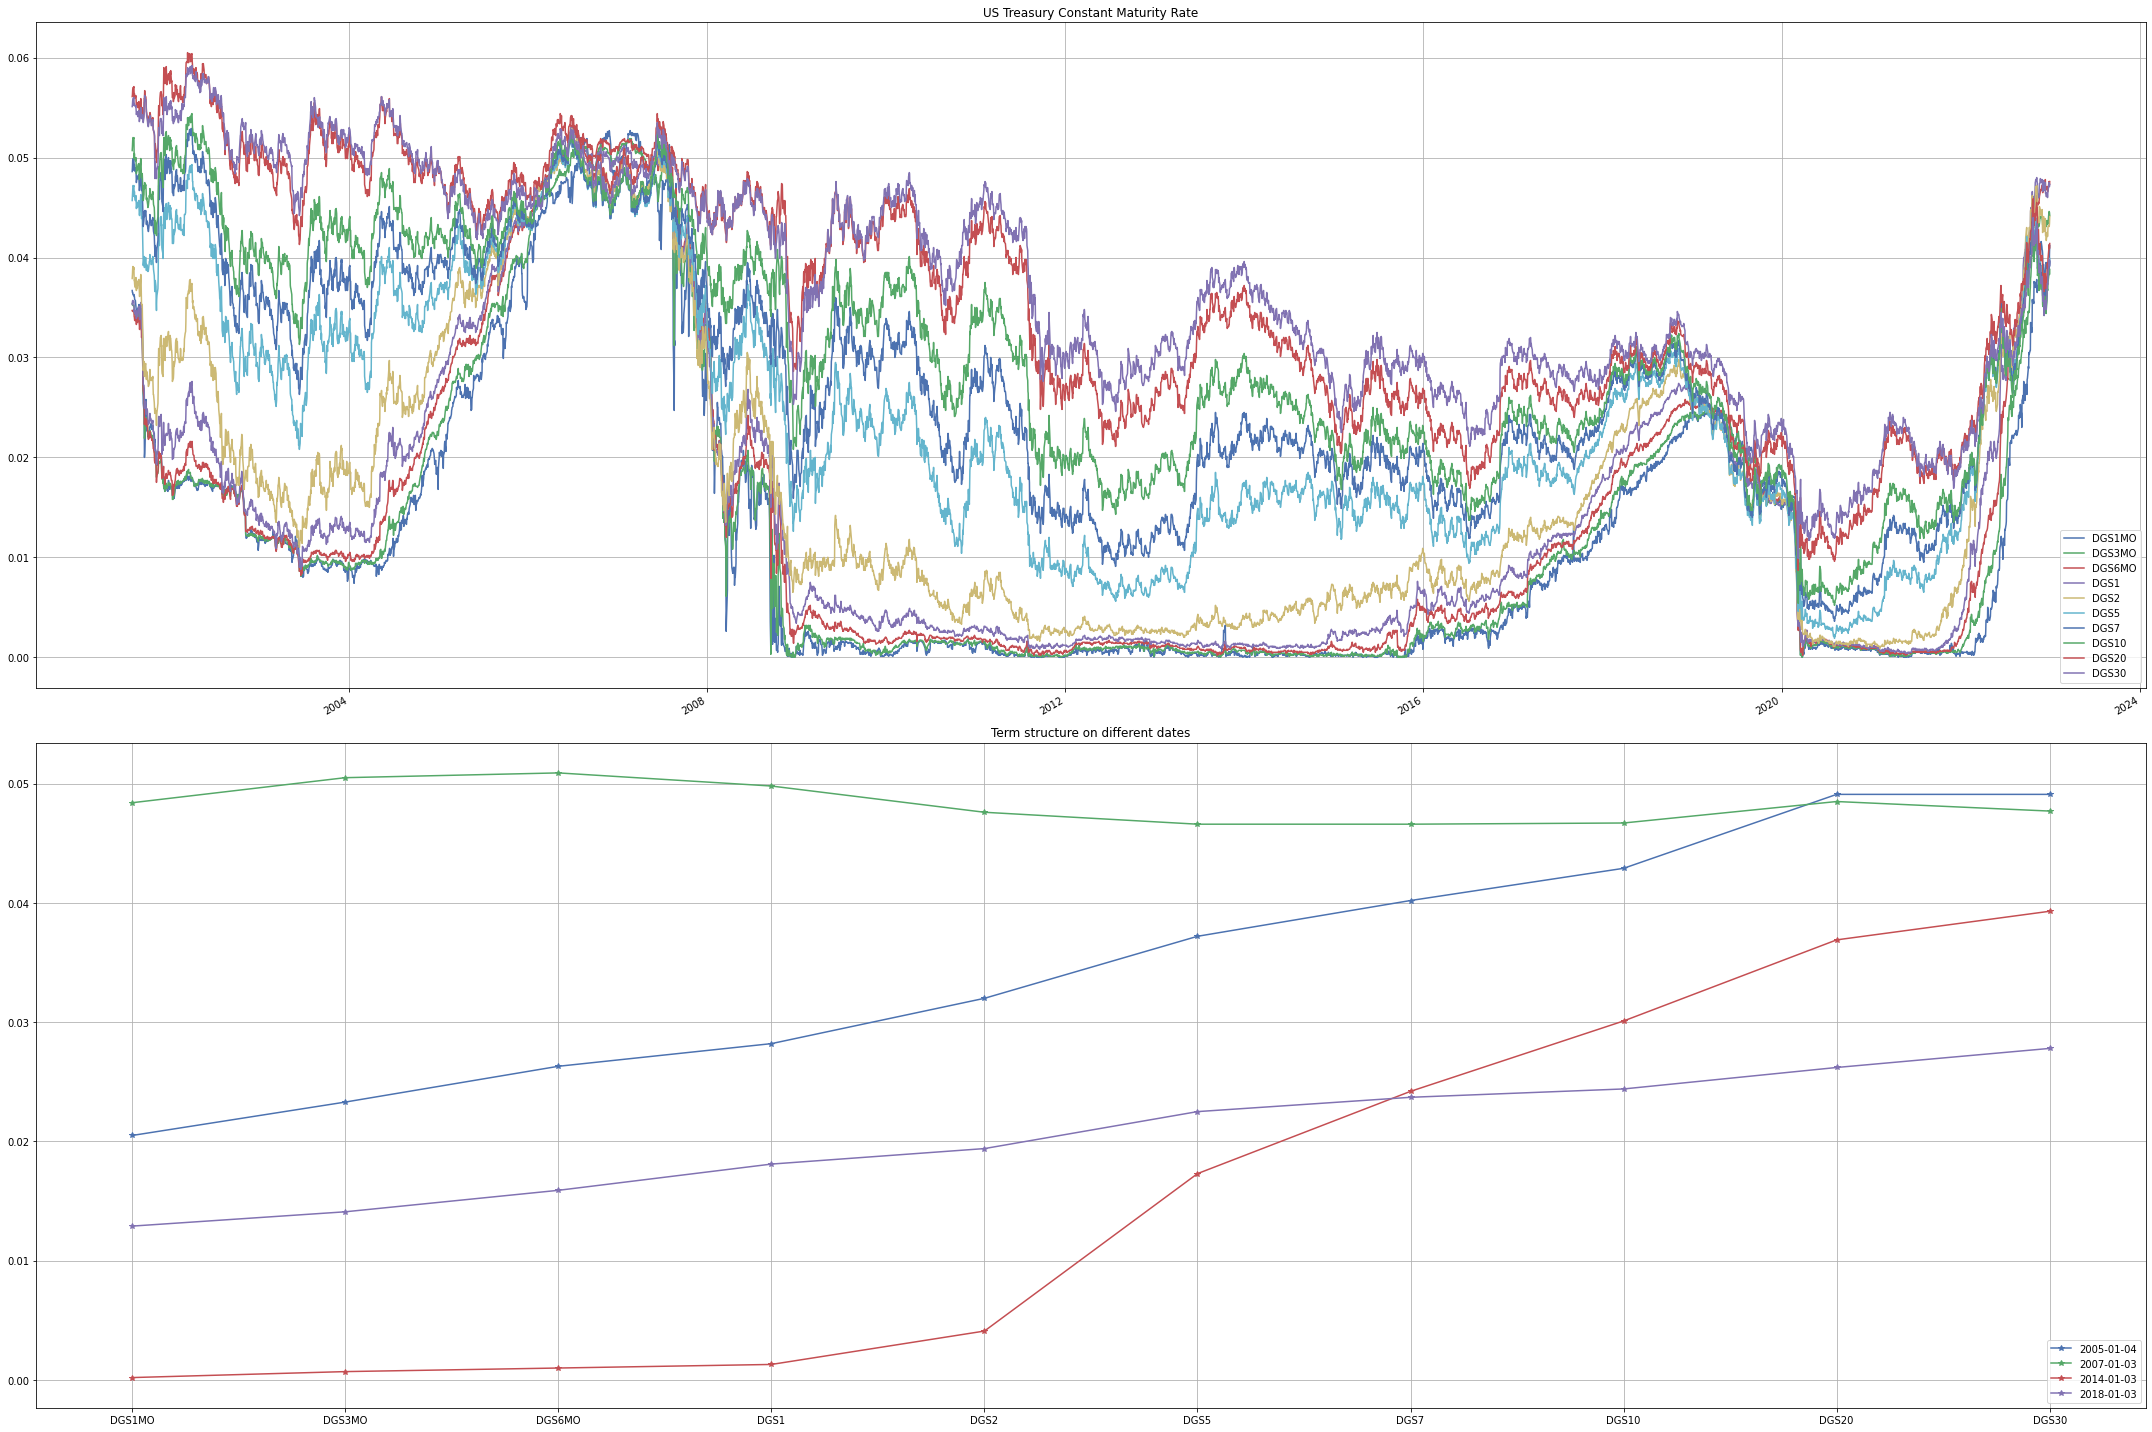

In [32]:
fig,(ax,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(30,20))
maturity_df.plot(grid=True,title='US Treasury Constant Maturity Rate',ax=ax)
x = maturity_df.loc[[datetime(2005,1,4),datetime(2007,1,3),datetime(2014,1,3),datetime(2018,1,3)],:]
x.index = [t.date() for t in x.index]
ax.legend(loc='lower right')
ax2.plot(x.T.index,x.T,marker='*')
ax2.legend(x.index, loc='lower right')
ax2.grid(True)
ax2.set_title('Term structure on different dates')
fig.tight_layout()

## Step 3 - Cleaning Data

Further steps are based on the following list of datasets:
* swap_df2, Swap rates
* treasury_df2, Treasury rates
* spread_df, rates Spreads


Selected IR instruments are considered for a wide range of maturities however terms less than one year were excluded as no swaps data was available for less than one year-maturities. The IR Swap Rates data is available for a period 2000-07-03 to 2016-10-28. The Federal Reserve Board has discontinued this series as of October 31, 2016. Treasury yields are available from 1962-01-02 till present. 

The resulting data set is limited with an interval for Swap rates data a period 2000-07-03 to 2016-10-28 which encounters 4078 observations of each rate.


In [33]:
treasury_df2 = pd.DataFrame()
treasury_df2 = combined_df.iloc[: , [0,1,2,3,4,5]].copy()

In [34]:
swap_df2.isnull().sum()

SWAP1     0
SWAP2     0
SWAP3     0
SWAP4     0
SWAP5     0
SWAP7     0
SWAP10    0
SWAP30    0
dtype: int64

In [35]:
treasury_df2.isnull().sum()

TRESY1y     0
TRESY2y     0
TRESY3y     0
TRESY5y     0
TRESY7y     0
TRESY10y    0
dtype: int64

In [36]:
spread_df.isnull().sum()

SPREAD1y     0
SPREAD2y     0
SPREAD3y     0
SPREAD5y     0
SPREAD7y     0
SPREAD10y    0
dtype: int64

In [37]:
combined_df2.isnull().sum()

TRESY1y     0
TRESY2y     0
TRESY3y     0
TRESY5y     0
TRESY7y     0
TRESY10y    0
SWAP1       0
SWAP2       0
SWAP3       0
SWAP4       0
SWAP5       0
SWAP7       0
SWAP10      0
SWAP30      0
^VIX        0
^GSPC       0
dtype: int64

We can see that there are no outliers nor null values. So, the data is clean.

## Step 4 - Visualizing rates data

### Swap rates data

#### Time series

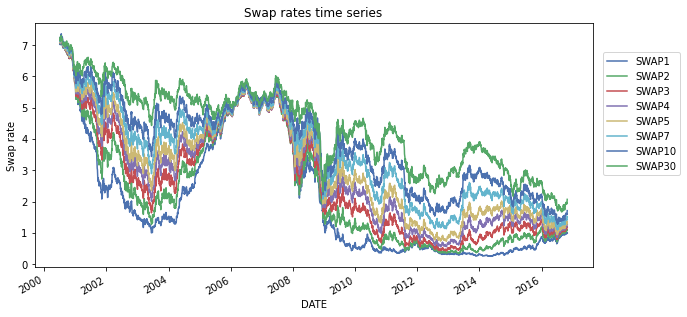

In [38]:
swap_df2.plot(figsize=(10,5))
plt.ylabel("Swap rate")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
plt.title("Swap rates time series")
plt.show()

#### Heat map

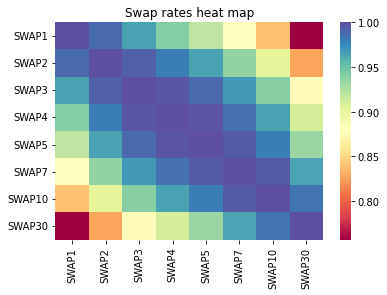

In [39]:
sns.heatmap(swap_df2.corr(), cmap="Spectral")
plt.title("Swap rates heat map")
plt.show()

#### Box plot

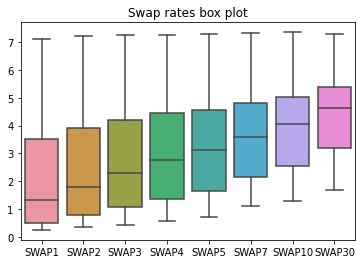

In [40]:
sns.boxplot(data=swap_df2)
plt.title("Swap rates box plot")
plt.show()

#### Density plot and descriptive statistics.

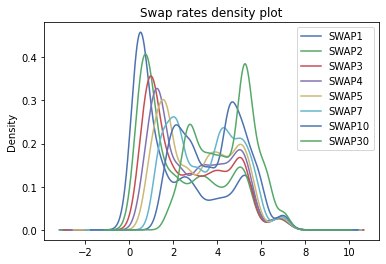

In [41]:
swap_df2.plot(kind = 'density')
plt.title("Swap rates density plot")
plt.show()

In [42]:
pd.set_option('display.max_colwidth', None)
all = pd.DataFrame()
all['median rate'] = swap_df2.median()
all['mean vs. median'] = swap_df2.mean() - swap_df2.median()
all['skewness'] = swap_df2.skew()
all['kurtosis'] = swap_df2.kurt()
descr = pd.DataFrame()
descr = swap_df2.describe().T.round(2)
result = pd.concat([descr, all], axis=1)
result.round(2)

count  mean   std   min   25%   50%   75%   max  median rate  \
SWAP1   4078.0  2.11  1.91  0.25  0.49  1.33  3.51  7.13         1.33   
SWAP2   4078.0  2.39  1.83  0.34  0.78  1.80  3.92  7.22         1.80   
SWAP3   4078.0  2.69  1.77  0.42  1.06  2.31  4.20  7.25         2.31   
SWAP4   4078.0  2.95  1.70  0.56  1.37  2.77  4.45  7.27         2.77   
SWAP5   4078.0  3.18  1.64  0.73  1.66  3.12  4.58  7.29         3.12   
SWAP7   4078.0  3.53  1.53  1.10  2.14  3.61  4.83  7.32         3.61   
SWAP10  4078.0  3.87  1.45  1.28  2.55  4.07  5.02  7.36         4.07   
SWAP30  4078.0  4.39  1.33  1.67  3.19  4.62  5.39  7.30         4.62   

        mean vs. median  skewness  kurtosis  
SWAP1              0.78      0.87     -0.56  
SWAP2              0.59      0.66     -0.82  
SWAP3              0.38      0.49     -0.98  
SWAP4              0.18      0.37     -1.04  
SWAP5              0.06      0.28     -1.07  
SWAP7             -0.08      0.16     -1.07  
SWAP10            -0.20      0.05     -1.05  
SWAP30            -0.23     -0.13     -1.04

### Treasury rates data

#### Time series

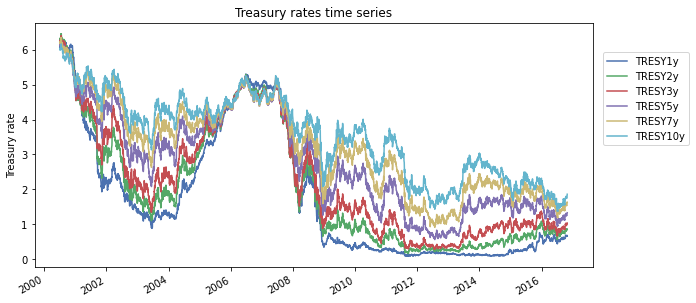

In [43]:
treasury_df2.plot(figsize=(10,5))
plt.ylabel("Treasury rate")
plt.legend(bbox_to_anchor=(1.01,.9), loc=2)
plt.title("Treasury rates time series")
plt.show()

#### Heat map

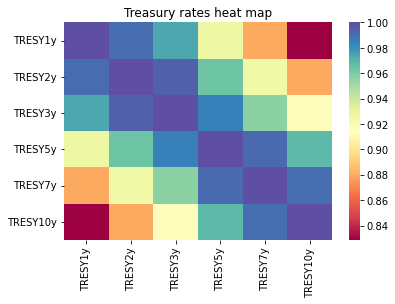

In [44]:
sns.heatmap(treasury_df2.corr(), cmap="Spectral")
plt.title("Treasury rates heat map")
plt.show()

#### Box plot

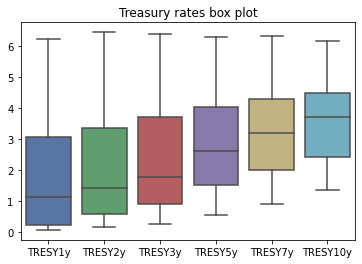

In [45]:
sns.boxplot(data=treasury_df2)
plt.title("Treasury rates box plot")
plt.show()

#### Density plot, skewness, kurtosis

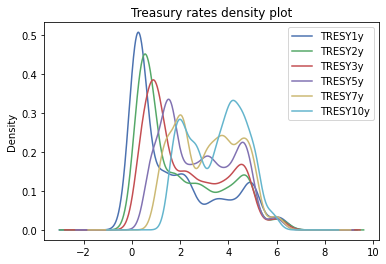

In [46]:
treasury_df2.plot(kind = 'density')
plt.title("Treasury rates density plot")
plt.show()

In [47]:
pd.set_option('display.max_colwidth', None)
all = pd.DataFrame()
all['median rate'] = treasury_df2.median()
all['mean vs. median'] = treasury_df2.mean() - treasury_df2.median()
all['skewness'] = treasury_df2.skew()
all['kurtosis'] = treasury_df2.kurt()
descr = pd.DataFrame()
descr = treasury_df2.describe().T.round(2)
result = pd.concat([descr, all], axis=1)
result.round(2)

count  mean   std   min   25%   50%   75%   max  median rate  \
TRESY1y   4078.0  1.76  1.81  0.08  0.24  1.15  3.09  6.25         1.15   
TRESY2y   4078.0  2.02  1.71  0.16  0.58  1.44  3.38  6.46         1.44   
TRESY3y   4078.0  2.28  1.61  0.28  0.91  1.79  3.71  6.40         1.79   
TRESY5y   4078.0  2.79  1.44  0.56  1.53  2.63  4.06  6.31         2.63   
TRESY7y   4078.0  3.18  1.31  0.91  2.02  3.21  4.32  6.35         3.21   
TRESY10y  4078.0  3.54  1.18  1.37  2.44  3.71  4.50  6.17         3.71   

          mean vs. median  skewness  kurtosis  
TRESY1y              0.61      0.90     -0.54  
TRESY2y              0.58      0.73     -0.78  
TRESY3y              0.49      0.58     -0.93  
TRESY5y              0.16      0.30     -1.10  
TRESY7y             -0.03      0.13     -1.09  
TRESY10y            -0.17     -0.07     -1.15

### Rates spread data

#### Time series

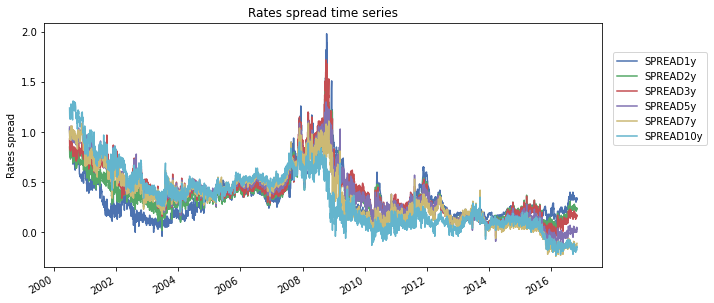

In [48]:
spread_df.plot(figsize=(10,5))
plt.ylabel("Rates spread")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
plt.title("Rates spread time series")
plt.show()

#### Heat map

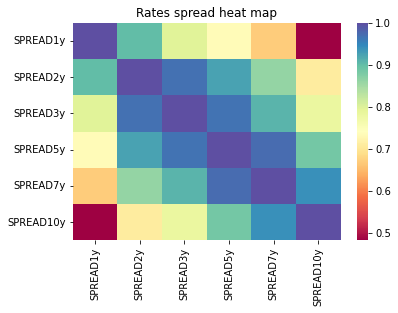

In [49]:
sns.heatmap(spread_df.corr(), cmap="Spectral")
plt.title("Rates spread heat map")
plt.show()

#### Box plot

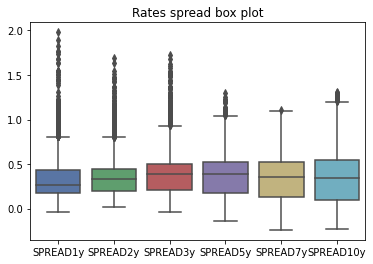

In [50]:
sns.boxplot(data=spread_df)
plt.title("Rates spread box plot")
plt.show()

#### Density plot, skewness, kurtosis

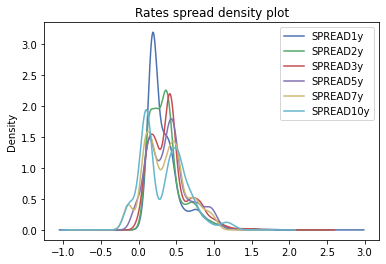

In [51]:
spread_df.plot(kind = 'density')
plt.title("Rates spread density plot")
plt.show()

In [52]:
pd.set_option('display.max_colwidth', None)
all = pd.DataFrame()
all['median rate'] = spread_df.median()
all['mean vs. median'] = spread_df.mean() - spread_df.median()
all['skewness'] = spread_df.skew()
all['kurtosis'] = spread_df.kurt()
descr = pd.DataFrame()
descr = spread_df.describe().T.round(2)
result = pd.concat([descr, all], axis=1)
result.round(2)

count  mean   std   min   25%   50%   75%   max  median rate  \
SPREAD1y   4078.0  0.34  0.24 -0.04  0.18  0.26  0.43  1.98         0.26   
SPREAD2y   4078.0  0.37  0.23  0.02  0.20  0.33  0.44  1.69         0.33   
SPREAD3y   4078.0  0.41  0.26 -0.04  0.21  0.39  0.50  1.72         0.39   
SPREAD5y   4078.0  0.40  0.27 -0.14  0.17  0.39  0.52  1.30         0.39   
SPREAD7y   4078.0  0.35  0.28 -0.24  0.13  0.35  0.52  1.11         0.35   
SPREAD10y  4078.0  0.34  0.30 -0.23  0.10  0.34  0.54  1.31         0.34   

           mean vs. median  skewness  kurtosis  
SPREAD1y              0.08      1.98      5.44  
SPREAD2y              0.04      1.46      2.83  
SPREAD3y              0.02      1.09      1.62  
SPREAD5y              0.01      0.56     -0.14  
SPREAD7y              0.00      0.34     -0.42  
SPREAD10y            -0.00      0.59      0.01

### Rates data and market indicators

In [53]:
corps = [ ('S&P 500',  '^GSPC'), ('CBOE Volatility Index', '^VIX')]
tickers = ["^VIX", "^GSPC"]

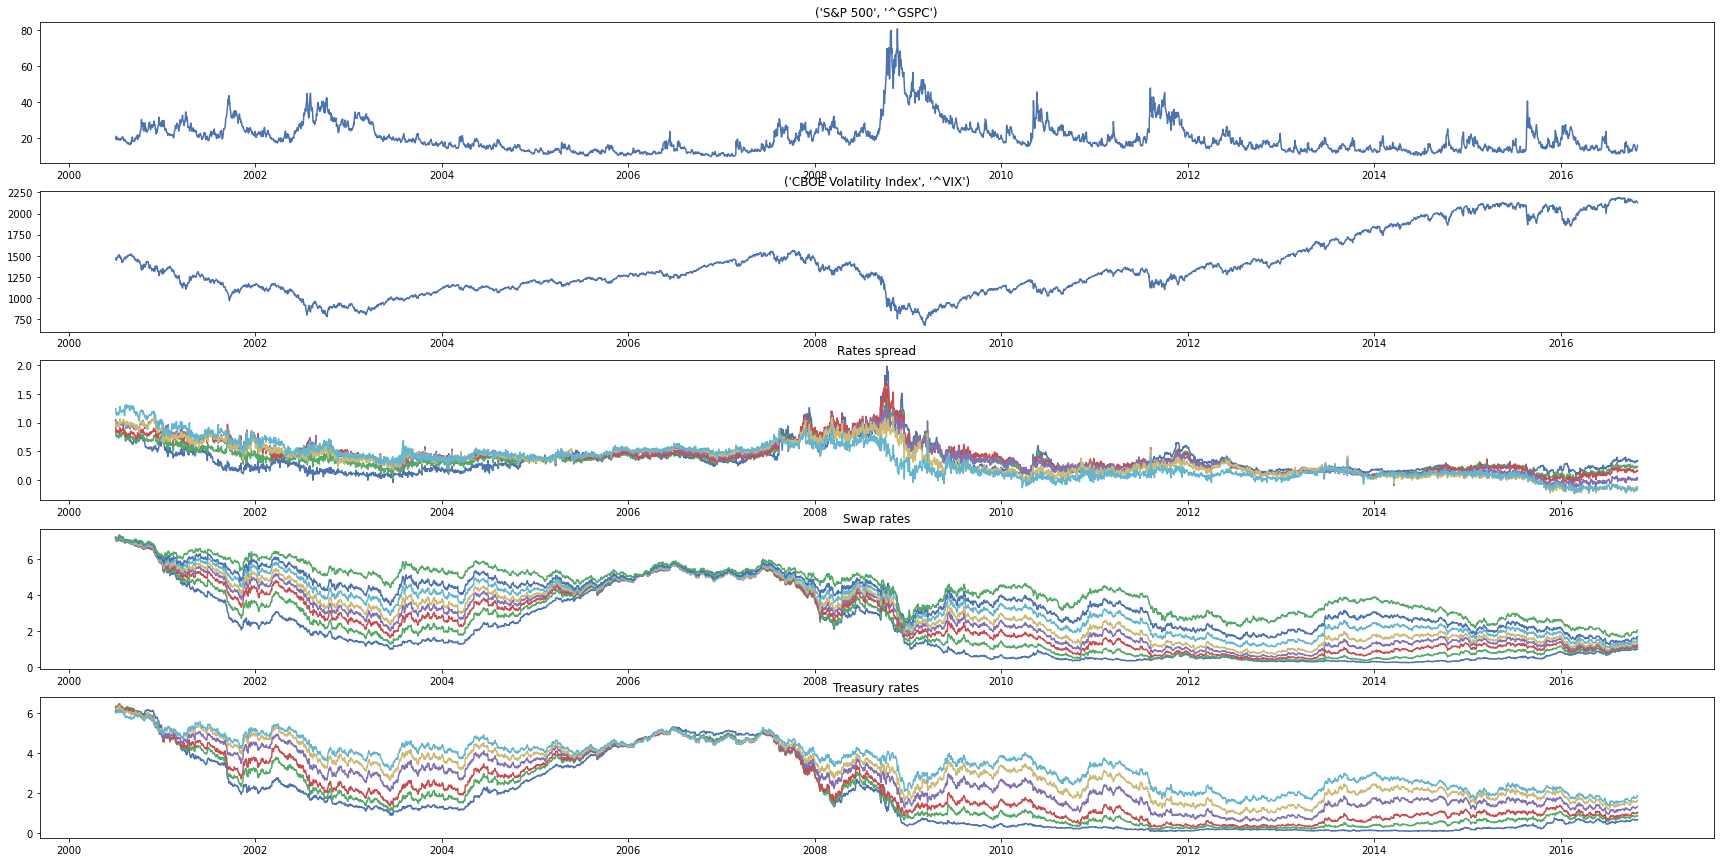

In [54]:
plt.figure(figsize=(30, 15))

plt.subplot(5,1,1)
plt.plot(combined_df2["^VIX"]);
plt.title(corps[0]);

plt.subplot(5,1,2)
plt.plot(combined_df2["^GSPC"]);
plt.title(corps[1]);

plt.subplot(5,1,3)
plt.plot(spread_df);
plt.title("Rates spread");

plt.subplot(5,1,4)
plt.plot(swap_df2);
plt.title("Swap rates");

plt.subplot(5,1,5)
plt.plot(treasury_df2);
plt.title("Treasury rates");

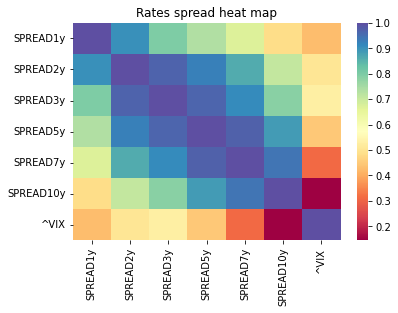

In [55]:
spread_df2 = spread_df.merge(prices_close["^VIX"], left_index=True, right_index=True) 
sns.heatmap(spread_df2.corr(), cmap="Spectral")
plt.title("Rates spread heat map")
plt.show()

## Step 5 - Stationarity tests applied to rates data

Stationarity tests are applied to the following list of datasets:
* swap_df2, Swap rates
* treasury_df2, Treasury rates
* spread_df, rates Spreads


### Swap rates data

#### ADF test

In [56]:
for i in range(len(swap_df2.columns)):
  result_adf = adf(swap_df2.iloc[:, [i]])
  print("ADF Result of",swap_df2.columns[i],":")
  print('ADF Statistic:', result_adf[0])
  print('p-value:', result_adf[1])
  print('Critical Values:')
  for key, value in result_adf[4].items():
    print('\t%s: %.3f' % (key, value))
  print("------------------------------------")

ADF Result of SWAP1 :
ADF Statistic: -2.5506390831803096
p-value: 0.10363422591686844
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SWAP2 :
ADF Statistic: -2.667295105214776
p-value: 0.079870627469744
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SWAP3 :
ADF Statistic: -2.472791152138088
p-value: 0.12223565327781993
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SWAP4 :
ADF Statistic: -2.346896661126757
p-value: 0.15728843816994081
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SWAP5 :
ADF Statistic: -2.2588791973805744
p-value: 0.1855732707057111
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SWAP7 :
ADF Statistic: -2.1274398926104086
p-value: 0.23362496640393038
Critical Values:
	1%: -3.432
	5%: -

#### KPSS test

In [57]:
for i in range(len(swap_df2.columns)):
  result_kpss = kpss(swap_df2.iloc[:, [i]])
  print("KPSS Result of",swap_df2.columns[i],":")
  print('KPSS Statistic:', result_kpss[0])
  print('p-value:', result_kpss[1])
  print('Critical Values:')
  for key, value in result_kpss[3].items():
      print('\t%s: %.3f' % (key, value))
  print("------------------------------------")

KPSS Result of SWAP1 :
KPSS Statistic: 5.1207659295990755
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SWAP2 :
KPSS Statistic: 6.2149764502444675
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SWAP3 :
KPSS Statistic: 6.976932851562482
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SWAP4 :
KPSS Statistic: 7.463710324376481
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SWAP5 :
KPSS Statistic: 7.8079326995799825
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SWAP7 :
KPSS Statistic: 8.233982825999687
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
--

#### PP test

In [58]:
for i in range(len(swap_df.columns)):
  ppt = pp(swap_df.iloc[:, [i]])
  print("PP Result of",swap_df.columns[i],":")
  print('PP Statistic:', ppt.stat)
  print('p-value:', ppt.pvalue)
  print("------------------------------------")

PP Result of SWAP1 :
PP Statistic: -2.7349917550306837
p-value: 0.06817641461814969
------------------------------------
PP Result of SWAP2 :
PP Statistic: -2.5907124578731304
p-value: 0.09493204699622082
------------------------------------
PP Result of SWAP3 :
PP Statistic: -2.409626584420197
p-value: 0.13903779034189978
------------------------------------
PP Result of SWAP4 :
PP Statistic: -2.2790106824103384
p-value: 0.17882682153316587
------------------------------------
PP Result of SWAP5 :
PP Statistic: -2.183821234854055
p-value: 0.21216972697102948
------------------------------------
PP Result of SWAP7 :
PP Statistic: -2.067736067084454
p-value: 0.2576843703590699
------------------------------------
PP Result of SWAP10 :
PP Statistic: -1.9509700654274504
p-value: 0.30847580030359273
------------------------------------
PP Result of SWAP30 :
PP Statistic: -1.6404874801037588
p-value: 0.46200608161449536
------------------------------------


### Treasury rates data

#### ADF test

In [59]:
for i in range(len(treasury_df2.columns)):
  result_adf = adf(treasury_df2.iloc[:, [i]])
  print("ADF Result of",treasury_df2.columns[i],":")
  print('ADF Statistic:', result_adf[0])
  print('p-value:', result_adf[1])
  print('Critical Values:')
  for key, value in result_adf[4].items():
    print('\t%s: %.3f' % (key, value))
  print("------------------------------------")

ADF Result of TRESY1y :
ADF Statistic: -2.3847150079533352
p-value: 0.14609703870471458
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of TRESY2y :
ADF Statistic: -2.5237164343037337
p-value: 0.10980997467407672
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of TRESY3y :
ADF Statistic: -2.36686602365768
p-value: 0.15130739403173815
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of TRESY5y :
ADF Statistic: -2.159530520788835
p-value: 0.22125988694196635
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of TRESY7y :
ADF Statistic: -2.1350422479487876
p-value: 0.23065931589479133
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of TRESY10y :
ADF Statistic: -1.9532366528192593
p-value: 0.30744581522250863
Critical Values:
	1

#### KPSS test

In [60]:
for i in range(len(treasury_df2.columns)):
  result_kpss = kpss(treasury_df2.iloc[:, [i]])
  print("KPSS Result of",treasury_df2.columns[i],":")
  print('KPSS Statistic:', result_kpss[0])
  print('p-value:', result_kpss[1])
  print('Critical Values:')
  for key, value in result_kpss[3].items():
      print('\t%s: %.3f' % (key, value))
  print("------------------------------------")

KPSS Result of TRESY1y :
KPSS Statistic: 5.3050531998058785
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of TRESY2y :
KPSS Statistic: 6.099906184319733
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of TRESY3y :
KPSS Statistic: 6.665214346529553
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of TRESY5y :
KPSS Statistic: 7.555165969394205
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of TRESY7y :
KPSS Statistic: 8.038293480140709
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of TRESY10y :
KPSS Statistic: 8.443933907424103
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1

#### PP test

In [61]:
for i in range(len(treasury_df2.columns)):
  ppt = pp(treasury_df2.iloc[:, [i]])
  print("PP Result of",treasury_df2.columns[i],":")
  print('PP Statistic:', ppt.stat)
  print('p-value:', ppt.pvalue)
  print("------------------------------------")

PP Result of TRESY1y :
PP Statistic: -2.4012444714426726
p-value: 0.14138547385489475
------------------------------------
PP Result of TRESY2y :
PP Statistic: -2.4632644111902686
p-value: 0.12467020466791529
------------------------------------
PP Result of TRESY3y :
PP Statistic: -2.3316788545382323
p-value: 0.1619543335774244
------------------------------------
PP Result of TRESY5y :
PP Statistic: -2.148740379004854
p-value: 0.22537255385534988
------------------------------------
PP Result of TRESY7y :
PP Statistic: -2.1234874345328776
p-value: 0.23517565692460446
------------------------------------
PP Result of TRESY10y :
PP Statistic: -1.9580275137440153
p-value: 0.3052741975480382
------------------------------------


### Rates spread data

#### ADF test

In [62]:
for i in range(len(spread_df.columns)):
  result_adf = adf(spread_df.iloc[:, [i]])
  print("ADF Result of",spread_df.columns[i],":")
  print('ADF Statistic:', result_adf[0])
  print('p-value:', result_adf[1])
  print('Critical Values:')
  for key, value in result_adf[4].items():
    print('\t%s: %.3f' % (key, value))
  print("------------------------------------")

ADF Result of SPREAD1y :
ADF Statistic: -2.9707636793555525
p-value: 0.0377163850010292
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SPREAD2y :
ADF Statistic: -2.6890001745767647
p-value: 0.0759611377920618
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SPREAD3y :
ADF Statistic: -2.4572488354469924
p-value: 0.12622556747463326
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SPREAD5y :
ADF Statistic: -2.183002700589333
p-value: 0.21247222939870714
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SPREAD7y :
ADF Statistic: -1.9559151188979993
p-value: 0.3062307965700831
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SPREAD10y :
ADF Statistic: -2.4409199754147726
p-value: 0.13051845333369727
Critical Value

#### KPSS test

In [63]:
for i in range(len(spread_df.columns)):
  result_kpss = kpss(spread_df.iloc[:, [i]])
  print("KPSS Result of",spread_df.columns[i],":")
  print('KPSS Statistic:', result_kpss[0])
  print('p-value:', result_kpss[1])
  print('Critical Values:')
  for key, value in result_kpss[3].items():
      print('\t%s: %.3f' % (key, value))
  print("------------------------------------")

KPSS Result of SPREAD1y :
KPSS Statistic: 1.0975395047890955
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SPREAD2y :
KPSS Statistic: 2.979551344123622
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SPREAD3y :
KPSS Statistic: 4.379706417525027
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SPREAD5y :
KPSS Statistic: 5.737629543627769
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SPREAD7y :
KPSS Statistic: 6.294869469822599
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SPREAD10y :
KPSS Statistic: 7.386750458440637
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.

#### PP test

In [64]:
for i in range(len(spread_df.columns)):
  ppt = pp(spread_df.iloc[:, [i]])
  print("PP Result of",spread_df.columns[i],":")
  print('PP Statistic:', ppt.stat)
  print('p-value:', ppt.pvalue)
  print("------------------------------------")

PP Result of SPREAD1y :
PP Statistic: -4.47954188499329
p-value: 0.00021407235267910374
------------------------------------
PP Result of SPREAD2y :
PP Statistic: -5.040709663541269
p-value: 1.842405288254238e-05
------------------------------------
PP Result of SPREAD3y :
PP Statistic: -4.664926654833204
p-value: 9.789018959555287e-05
------------------------------------
PP Result of SPREAD5y :
PP Statistic: -4.715520167765495
p-value: 7.868129844236892e-05
------------------------------------
PP Result of SPREAD7y :
PP Statistic: -4.2228801553990785
p-value: 0.0006025407852610575
------------------------------------
PP Result of SPREAD10y :
PP Statistic: -3.841410638420049
p-value: 0.0025109395585149762
------------------------------------


## Step 6 - Transforming rates data into rates pct changes.

The time series of interest rates is not stationary, i.e. interest rates are stochastic processes in which the probability distribution changes. This feature of the non-stationary process affects the quality of the principal component analysis. 

Interest rate time series are replaced with interest rate changes time series.

Interest rates time series are replaced with interest rates changes: 
* swap_df2 ---> swap_df3, Swap rates
* treasury_df2 ---> treasury_df3 , Treasury rates
* spread_df ---> spread_df3 , rates Spreads


In [65]:
swap_df3 = pd.DataFrame()
swap_df3 = swap_df2.pct_change()
swap_df3 = swap_df3.dropna()
swap_df3.head(2)

SWAP1     SWAP2     SWAP3     SWAP4     SWAP5     SWAP7  \
DATE                                                                     
2000-07-05 -0.009859 -0.013966 -0.013947 -0.013947 -0.012552 -0.012500   
2000-07-06  0.005690  0.009915  0.009901  0.011315  0.011299  0.011252   

              SWAP10    SWAP30  
DATE                            
2000-07-05 -0.013812 -0.011050  
2000-07-06  0.009804  0.006983

In [66]:
treasury_df3 = pd.DataFrame()
treasury_df3 = treasury_df2.pct_change()
treasury_df3 = treasury_df3.dropna()
treasury_df3.head(2)

TRESY1y   TRESY2y   TRESY3y   TRESY5y   TRESY7y  TRESY10y
2000-07-05 -0.001647 -0.003170 -0.001603  0.000000 -0.001616 -0.001667
2000-07-06  0.006601  0.007949  0.008026  0.006536  0.009709  0.010017

In [67]:
spread_df3 = pd.DataFrame()
spread_df3 = spread_df.pct_change()
spread_df3 = spread_df3.dropna()
spread_df3.head(2)

SPREAD1y  SPREAD2y  SPREAD3y  SPREAD5y  SPREAD7y  SPREAD10y
2000-07-05 -0.058252 -0.094118 -0.096774 -0.085714 -0.079208  -0.072581
2000-07-06  0.000000  0.025974  0.023810  0.041667  0.021505   0.008696

## Step 7 - Visualizing rates pct changes data

### Swap rates pct changes data

#### Time series

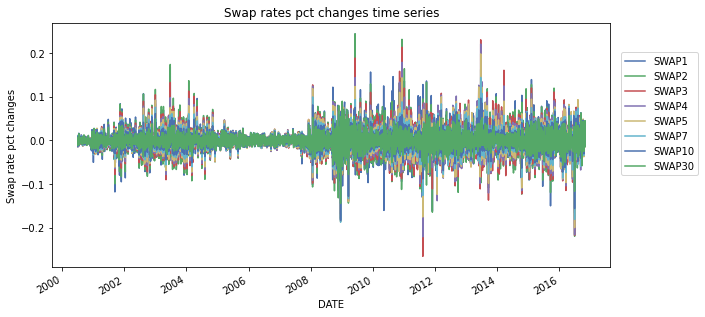

In [68]:
swap_df3.plot(figsize=(10,5))
plt.ylabel("Swap rate pct changes")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
plt.title("Swap rates pct changes time series")
plt.show()

#### Heat map

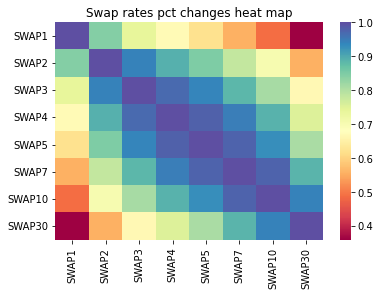

In [69]:
sns.heatmap(swap_df3.corr(), cmap="Spectral")
plt.title("Swap rates pct changes heat map")
plt.show()

#### Box plot

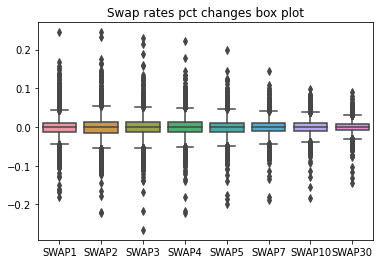

In [70]:
sns.boxplot(data=swap_df3)
plt.title("Swap rates pct changes box plot")
plt.show()

#### Density plot and descriptive statistics.

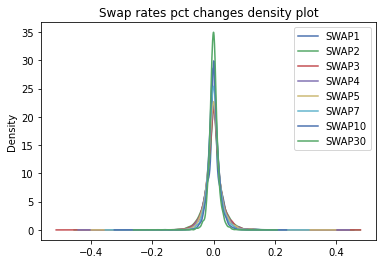

In [71]:
swap_df3.plot(kind = 'density')
plt.title("Swap rates pct changes density plot")
plt.show()

In [72]:
pd.set_option('display.max_colwidth', None)
all = pd.DataFrame()
all['median rate'] = swap_df3.median()
all['mean vs. median'] = swap_df3.mean() - swap_df3.median()
all['skewness'] = swap_df3.skew()
all['kurtosis'] = swap_df3.kurt()
descr = pd.DataFrame()
descr = swap_df3.describe().T.round(2)
result = pd.concat([descr, all], axis=1)
result.round(2)

count  mean   std   min   25%  50%   75%   max  median rate  \
SWAP1   4077.0  -0.0  0.03 -0.18 -0.01  0.0  0.01  0.24          0.0   
SWAP2   4077.0   0.0  0.03 -0.22 -0.01  0.0  0.01  0.24          0.0   
SWAP3   4077.0  -0.0  0.03 -0.27 -0.01  0.0  0.01  0.23          0.0   
SWAP4   4077.0  -0.0  0.03 -0.22 -0.01  0.0  0.01  0.22          0.0   
SWAP5   4077.0  -0.0  0.02 -0.20 -0.01  0.0  0.01  0.20          0.0   
SWAP7   4077.0  -0.0  0.02 -0.19 -0.01  0.0  0.01  0.14          0.0   
SWAP10  4077.0  -0.0  0.02 -0.18 -0.01  0.0  0.01  0.10          0.0   
SWAP30  4077.0  -0.0  0.02 -0.14 -0.01  0.0  0.01  0.09          0.0   

        mean vs. median  skewness  kurtosis  
SWAP1              -0.0      0.31      6.54  
SWAP2               0.0      0.23      5.99  
SWAP3              -0.0      0.13      6.85  
SWAP4              -0.0      0.09      6.35  
SWAP5              -0.0      0.05      5.58  
SWAP7              -0.0     -0.10      5.36  
SWAP10             -0.0     -0.24      5.87  
SWAP30             -0.0     -0.32      6.77

### Treasury rates pct changes data

#### Time series

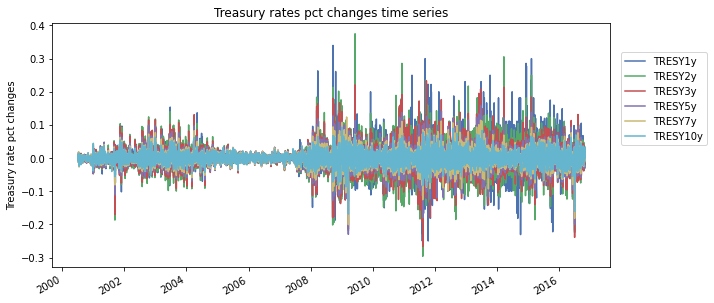

In [73]:
treasury_df3.plot(figsize=(10,5))
plt.ylabel("Treasury rate pct changes")
plt.legend(bbox_to_anchor=(1.01,.9), loc=2)
plt.title("Treasury rates pct changes time series")
plt.show()

#### Heat map

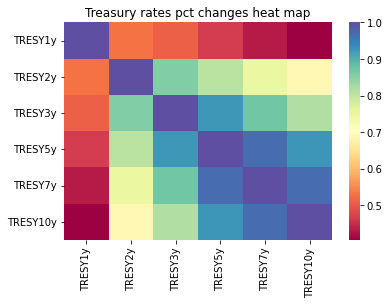

In [74]:
sns.heatmap(treasury_df3.corr(), cmap="Spectral")
plt.title("Treasury rates pct changes heat map")
plt.show()

#### Box plot

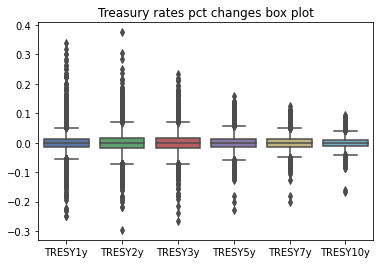

In [75]:
sns.boxplot(data=treasury_df3)
plt.title("Treasury rates pct changes box plot")
plt.show()

#### Density plot, skewness, kurtosis

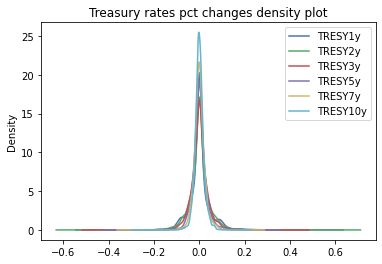

In [76]:
treasury_df3.plot(kind = 'density')
plt.title("Treasury rates pct changes density plot")
plt.show()

In [77]:
pd.set_option('display.max_colwidth', None)
all = pd.DataFrame()
all['median rate'] = treasury_df3.median()
all['mean vs. median'] = treasury_df3.mean() - treasury_df3.median()
all['skewness'] = treasury_df3.skew()
all['kurtosis'] = treasury_df3.kurt()
descr = pd.DataFrame()
descr = treasury_df3.describe().T.round(2)
result = pd.concat([descr, all], axis=1)
result.round(2)

count  mean   std   min   25%  50%   75%   max  median rate  \
TRESY1y   4077.0   0.0  0.05 -0.25 -0.02  0.0  0.01  0.34          0.0   
TRESY2y   4077.0   0.0  0.05 -0.30 -0.02  0.0  0.02  0.38          0.0   
TRESY3y   4077.0   0.0  0.04 -0.27 -0.02  0.0  0.02  0.23          0.0   
TRESY5y   4077.0   0.0  0.03 -0.23 -0.02  0.0  0.01  0.16          0.0   
TRESY7y   4077.0  -0.0  0.02 -0.20 -0.01  0.0  0.01  0.12          0.0   
TRESY10y  4077.0  -0.0  0.02 -0.17 -0.01  0.0  0.01  0.09          0.0   

          mean vs. median  skewness  kurtosis  
TRESY1y               0.0      0.75      6.61  
TRESY2y               0.0      0.41      5.21  
TRESY3y               0.0      0.26      4.58  
TRESY5y               0.0      0.13      4.09  
TRESY7y              -0.0      0.09      3.96  
TRESY10y             -0.0     -0.05      4.01

### Rates spread pct changes data

In [78]:
#rebuild a new spread data set
combined_df3 = treasury_df3.merge(swap_df3, left_index=True, right_index=True)

spread3 = [combined_df3.SWAP1-combined_df3.TRESY1y, 
        combined_df3.SWAP2-combined_df3.TRESY2y,
       combined_df3.SWAP3-combined_df3.TRESY3y,
       combined_df3.SWAP5-combined_df3.TRESY5y,
       combined_df3.SWAP7-combined_df3.TRESY7y,
       combined_df3.SWAP10-combined_df3.TRESY10y]
spread_df3 = pd.DataFrame(np.array(spread3).T, index=combined_df3.index, 
                         columns = ["SPREAD1y", "SPREAD2y", "SPREAD3y", "SPREAD5y", "SPREAD7y", "SPREAD10y"])


#### Time series

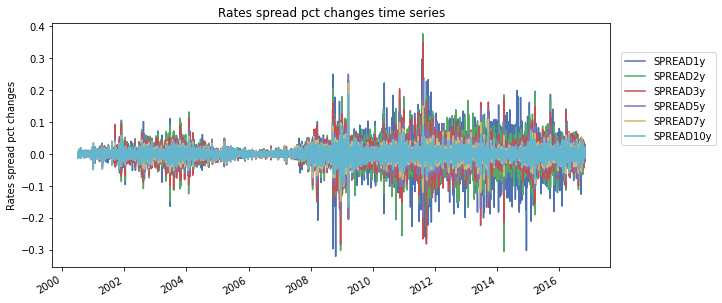

In [79]:
spread_df3.plot(figsize=(10,5))
plt.ylabel("Rates spread pct changes")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
plt.title("Rates spread pct changes time series")
plt.show()

#### Heat map

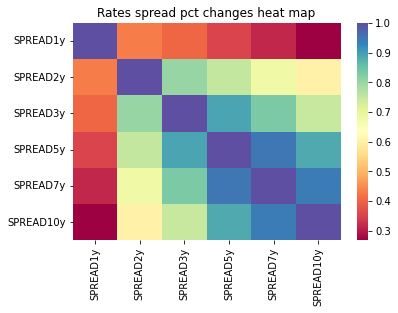

In [80]:
sns.heatmap(spread_df3.corr(), cmap="Spectral")
plt.title("Rates spread pct changes heat map")
plt.show()

#### Box plot

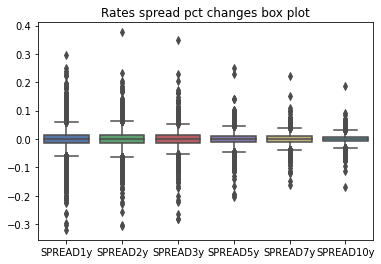

In [81]:
sns.boxplot(data=spread_df3)
plt.title("Rates spread pct changes box plot")
plt.show()

#### Density plot, skewness, kurtosis

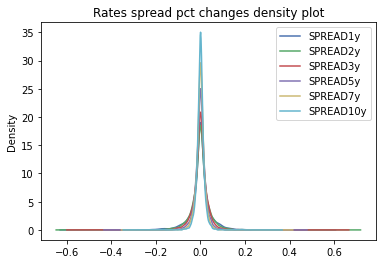

In [82]:
spread_df3.plot(kind = 'density')
plt.title("Rates spread pct changes density plot")
plt.show()

In [83]:
pd.set_option('display.max_colwidth', None)
all = pd.DataFrame()
all['median rate'] = spread_df3.median()
all['mean vs. median'] = spread_df3.mean() - spread_df3.median()
all['skewness'] = spread_df3.skew()
all['kurtosis'] = spread_df3.kurt()
descr = pd.DataFrame()
descr = spread_df3.describe().T.round(2)
result = pd.concat([descr, all], axis=1)
result.round(2)

count  mean   std   min   25%  50%   75%   max  median rate  \
SPREAD1y   4077.0  -0.0  0.05 -0.32 -0.01  0.0  0.02  0.30          0.0   
SPREAD2y   4077.0  -0.0  0.04 -0.31 -0.02  0.0  0.02  0.38          0.0   
SPREAD3y   4077.0  -0.0  0.03 -0.28 -0.01  0.0  0.01  0.35          0.0   
SPREAD5y   4077.0  -0.0  0.02 -0.21 -0.01  0.0  0.01  0.25          0.0   
SPREAD7y   4077.0  -0.0  0.02 -0.16 -0.01  0.0  0.01  0.22          0.0   
SPREAD10y  4077.0  -0.0  0.02 -0.17 -0.01  0.0  0.01  0.19          0.0   

           mean vs. median  skewness  kurtosis  
SPREAD1y              -0.0     -0.49      6.46  
SPREAD2y              -0.0     -0.21      7.43  
SPREAD3y              -0.0     -0.26     10.95  
SPREAD5y              -0.0     -0.08     10.17  
SPREAD7y              -0.0      0.00      9.07  
SPREAD10y             -0.0     -0.06      9.71

## Step 8 - Stationarity tests applied to rates pct changes data

Stationarity tests are applied to the following list of datasets:
* swap_df3, Swap rates pct changes
* treasury_df3, Treasury rates pct changes
* spread_df3, rates Spreads pct changes


### Swap rates data

#### ADF test

In [84]:
for i in range(len(swap_df3.columns)):
  result_adf_3 = adf(swap_df3.iloc[:, [i]])
  print("ADF Result of",swap_df3.columns[i],":")
  print('ADF Statistic:', result_adf_3[0])
  print('p-value:', result_adf_3[1])
  print('Critical Values:')
  for key, value in result_adf_3[4].items():
    print('\t%s: %.3f' % (key, value))
  print("------------------------------------")

ADF Result of SWAP1 :
ADF Statistic: -23.238521026387744
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SWAP2 :
ADF Statistic: -20.514733291182264
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SWAP3 :
ADF Statistic: -20.4911834662319
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SWAP4 :
ADF Statistic: -20.598172622813525
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SWAP5 :
ADF Statistic: -20.956702222673048
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SWAP7 :
ADF Statistic: -11.214265903111038
p-value: 2.088456254866588e-20
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SWAP

#### KPSS test

In [85]:
for i in range(len(swap_df3.columns)):
  result_kpss = kpss(swap_df3.iloc[:, [i]])
  print("KPSS Result of",swap_df3.columns[i],":")
  print('KPSS Statistic:', result_kpss[0])
  print('p-value:', result_kpss[1])
  print('Critical Values:')
  for key, value in result_kpss[3].items():
      print('\t%s: %.3f' % (key, value))
  print("------------------------------------")

KPSS Result of SWAP1 :
KPSS Statistic: 0.3894760601298725
p-value: 0.08169135339229633
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SWAP2 :
KPSS Statistic: 0.21760515638931294
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SWAP3 :
KPSS Statistic: 0.1510630822910997
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SWAP4 :
KPSS Statistic: 0.10773410563639513
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SWAP5 :
KPSS Statistic: 0.07492214416001679
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SWAP7 :
KPSS Statistic: 0.043965403254355405
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0

#### PP test

In [86]:
for i in range(len(swap_df3.columns)):
  ppt = pp(swap_df3.iloc[:, [i]])
  print("PP Result of",swap_df3.columns[i],":")
  print('PP Statistic:', ppt.stat)
  print('p-value:', ppt.pvalue)
  print("------------------------------------")

PP Result of SWAP1 :
PP Statistic: -63.24752019669821
p-value: 0.0
------------------------------------
PP Result of SWAP2 :
PP Statistic: -64.14278460572346
p-value: 0.0
------------------------------------
PP Result of SWAP3 :
PP Statistic: -64.05436768062455
p-value: 0.0
------------------------------------
PP Result of SWAP4 :
PP Statistic: -64.53498121810595
p-value: 0.0
------------------------------------
PP Result of SWAP5 :
PP Statistic: -64.29514522354926
p-value: 0.0
------------------------------------
PP Result of SWAP7 :
PP Statistic: -64.21462779064767
p-value: 0.0
------------------------------------
PP Result of SWAP10 :
PP Statistic: -63.472377605437245
p-value: 0.0
------------------------------------
PP Result of SWAP30 :
PP Statistic: -62.638668441662546
p-value: 0.0
------------------------------------


### Treasury rates data

#### ADF test

In [87]:
for i in range(len(treasury_df3.columns)):
  result_adf = adf(treasury_df3.iloc[:, [i]])
  print("ADF Result of",treasury_df3.columns[i],":")
  print('ADF Statistic:', result_adf[0])
  print('p-value:', result_adf[1])
  print('Critical Values:')
  for key, value in result_adf[4].items():
    print('\t%s: %.3f' % (key, value))
  print("------------------------------------")

ADF Result of TRESY1y :
ADF Statistic: -13.51589277723714
p-value: 2.794930156175347e-25
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of TRESY2y :
ADF Statistic: -28.650209686588553
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of TRESY3y :
ADF Statistic: -13.767758546201723
p-value: 9.811726607131971e-26
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of TRESY5y :
ADF Statistic: -30.37788674165114
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of TRESY7y :
ADF Statistic: -30.8208545100696
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of TRESY10y :
ADF Statistic: -30.771792336493824
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
--------------------------

#### KPSS test

In [88]:
for i in range(len(treasury_df3.columns)):
  result_kpss = kpss(treasury_df3.iloc[:, [i]])
  print("KPSS Result of",treasury_df3.columns[i],":")
  print('KPSS Statistic:', result_kpss[0])
  print('p-value:', result_kpss[1])
  print('Critical Values:')
  for key, value in result_kpss[3].items():
      print('\t%s: %.3f' % (key, value))
  print("------------------------------------")

KPSS Result of TRESY1y :
KPSS Statistic: 0.6360971802548226
p-value: 0.01935480179501612
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of TRESY2y :
KPSS Statistic: 0.3451976679425331
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of TRESY3y :
KPSS Statistic: 0.18522797278759207
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of TRESY5y :
KPSS Statistic: 0.092179762159823
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of TRESY7y :
KPSS Statistic: 0.05665649124916637
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of TRESY10y :
KPSS Statistic: 0.026509873058787173
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.4

#### PP test

In [89]:
for i in range(len(treasury_df3.columns)):
  ppt = pp(treasury_df3.iloc[:, [i]])
  print("PP Result of",treasury_df3.columns[i],":")
  print('PP Statistic:', ppt.stat)
  print('p-value:', ppt.pvalue)
  print("------------------------------------")

PP Result of TRESY1y :
PP Statistic: -73.17152016275986
p-value: 0.0
------------------------------------
PP Result of TRESY2y :
PP Statistic: -72.65861600308216
p-value: 0.0
------------------------------------
PP Result of TRESY3y :
PP Statistic: -66.4090853613199
p-value: 0.0
------------------------------------
PP Result of TRESY5y :
PP Statistic: -66.24676474316904
p-value: 0.0
------------------------------------
PP Result of TRESY7y :
PP Statistic: -65.29790616562694
p-value: 0.0
------------------------------------
PP Result of TRESY10y :
PP Statistic: -64.57484216050152
p-value: 0.0
------------------------------------


### Rates spread data

#### ADF test

In [90]:
for i in range(len(spread_df3.columns)):
  result_adf = adf(spread_df3.iloc[:, [i]])
  print("ADF Result of",spread_df3.columns[i],":")
  print('ADF Statistic:', result_adf[0])
  print('p-value:', result_adf[1])
  print('Critical Values:')
  for key, value in result_adf[4].items():
    print('\t%s: %.3f' % (key, value))
  print("------------------------------------")

ADF Result of SPREAD1y :
ADF Statistic: -14.134153422080328
p-value: 2.3058089115578325e-26
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SPREAD2y :
ADF Statistic: -29.69672705820064
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SPREAD3y :
ADF Statistic: -13.153620012157008
p-value: 1.3511784388592338e-24
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SPREAD5y :
ADF Statistic: -29.926279377285727
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SPREAD7y :
ADF Statistic: -30.98039045733669
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
------------------------------------
ADF Result of SPREAD10y :
ADF Statistic: -23.359393422380254
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
----------------

#### KPSS test

In [91]:
for i in range(len(spread_df3.columns)):
  result_kpss = kpss(spread_df3.iloc[:, [i]])
  print("KPSS Result of",spread_df3.columns[i],":")
  print('KPSS Statistic:', result_kpss[0])
  print('p-value:', result_kpss[1])
  print('Critical Values:')
  for key, value in result_kpss[3].items():
      print('\t%s: %.3f' % (key, value))
  print("------------------------------------")

KPSS Result of SPREAD1y :
KPSS Statistic: 0.308480793559414
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SPREAD2y :
KPSS Statistic: 0.3136284929864392
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SPREAD3y :
KPSS Statistic: 0.18988427206493244
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SPREAD5y :
KPSS Statistic: 0.15331809558861836
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SPREAD7y :
KPSS Statistic: 0.14844575584419795
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
------------------------------------
KPSS Result of SPREAD10y :
KPSS Statistic: 0.09106886815698946
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 

#### PP test

In [92]:
for i in range(len(spread_df3.columns)):
  ppt = pp(spread_df3.iloc[:, [i]])
  print("PP Result of",spread_df3.columns[i],":")
  print('PP Statistic:', ppt.stat)
  print('p-value:', ppt.pvalue)
  print("------------------------------------")

PP Result of SPREAD1y :
PP Statistic: -86.94838348216788
p-value: 0.0
------------------------------------
PP Result of SPREAD2y :
PP Statistic: -124.13942890123576
p-value: 0.0
------------------------------------
PP Result of SPREAD3y :
PP Statistic: -131.03200191819397
p-value: 0.0
------------------------------------
PP Result of SPREAD5y :
PP Statistic: -159.6359684377999
p-value: 0.0
------------------------------------
PP Result of SPREAD7y :
PP Statistic: -171.51005352769374
p-value: 0.0
------------------------------------
PP Result of SPREAD10y :
PP Statistic: -192.1259525020069
p-value: 0.0
------------------------------------


## Step 9 - Applying PCA to data

### Defined Functions

In [93]:
def mPCA(df, num_reconstruct):
    
    df -= df.mean(axis=0)
    R = np.cov(df, rowvar=False)
    eigenvals, eigenvecs = sp.linalg.eigh(R)
    eigenvecs = eigenvecs[:, np.argsort(eigenvals)[::-1]]
    eigenvals = eigenvals[np.argsort(eigenvals)[::-1]]
    eigenvecs = eigenvecs[:, :num_reconstruct]

    return np.dot(eigenvecs.T, df.T).T, eigenvals, eigenvecs

### PCA to Swap rates pct changes

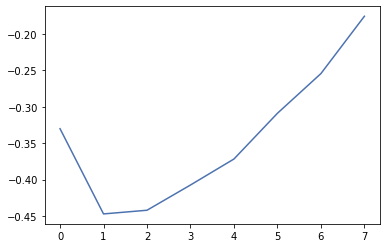

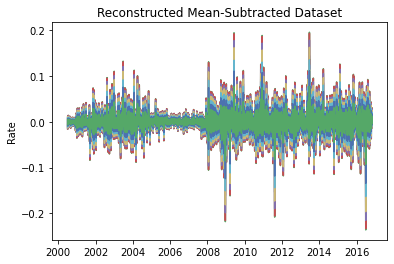

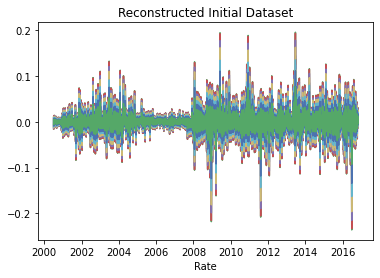

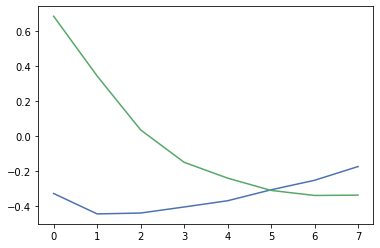

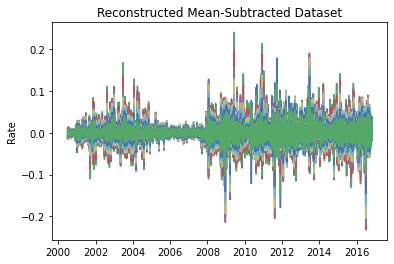

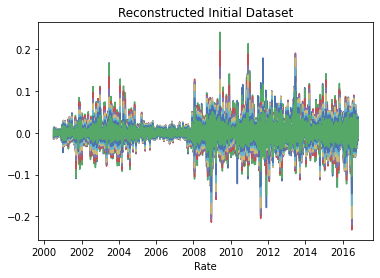

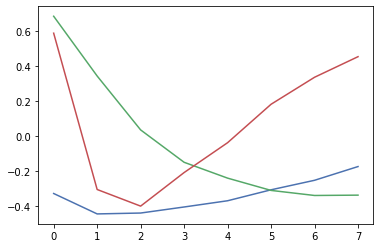

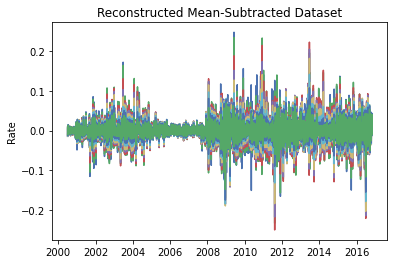

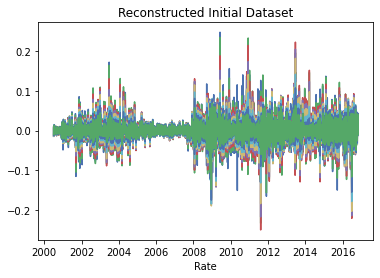

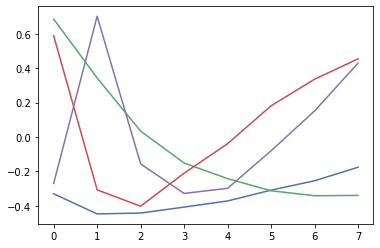

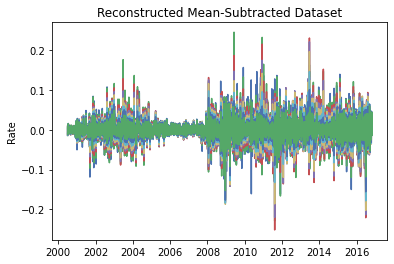

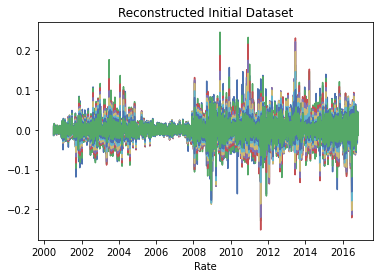

In [94]:
vec = [1,2,3,4]

for i in vec:
  scores, evals, evecs = mPCA(swap_df3, i)
  evecs = pd.DataFrame(evecs)
  plt.plot(evecs)
  plt.show()
  reconst = pd.DataFrame(np.dot(scores,evecs.T), index=swap_df3.index, columns=swap_df3.columns)
  plt.plot(reconst)
  plt.ylabel("Rate")
  plt.title("Reconstructed Mean-Subtracted Dataset")
  plt.show()
  for cols in reconst.columns:
    reconst[cols] = reconst[cols] + swap_df3.mean(axis=0)[cols]
  plt.plot(reconst)
  plt.xlabel("Rate")
  plt.title("Reconstructed Initial Dataset")
  plt.show()

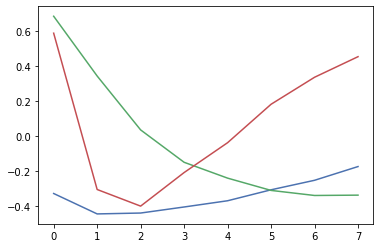

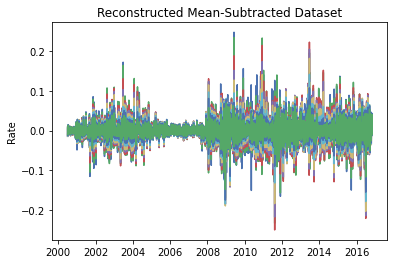

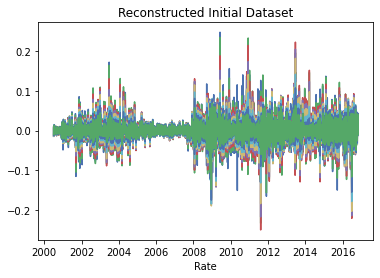

In [95]:
vec = 3
scores, evals, evecs = mPCA(swap_df3, vec)
evecs = pd.DataFrame(evecs)
plt.plot(evecs)
plt.show()
reconst = pd.DataFrame(np.dot(scores,evecs.T), index=swap_df3.index, columns=swap_df3.columns)
plt.plot(reconst)
plt.ylabel("Rate")
plt.title("Reconstructed Mean-Subtracted Dataset")
plt.show()
for cols in reconst.columns:
  reconst[cols] = reconst[cols] + swap_df3.mean(axis=0)[cols]
plt.plot(reconst)
plt.xlabel("Rate")
plt.title("Reconstructed Initial Dataset")
def PCA(df, num_reconstruct):
    
    df -= df.mean(axis=0)
    R = np.cov(df, rowvar=False)
    eigenvals, eigenvecs = sp.linalg.eigh(R)
    eigenvecs = eigenvecs[:, np.argsort(eigenvals)[::-1]]
    eigenvals = eigenvals[np.argsort(eigenvals)[::-1]]
    eigenvecs = eigenvecs[:, :num_reconstruct]

    return np.dot(eigenvecs.T, df.T).T, eigenvals, eigenvecsplt.show()

### PCA to Treasury dataset

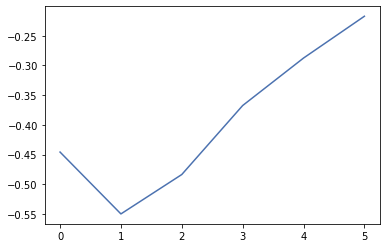

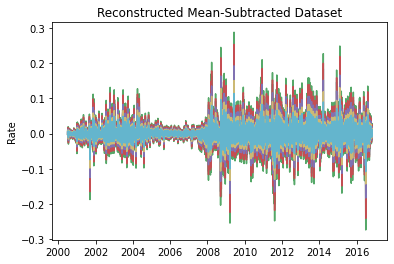

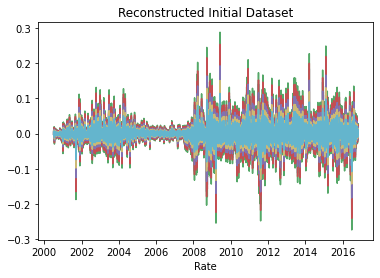

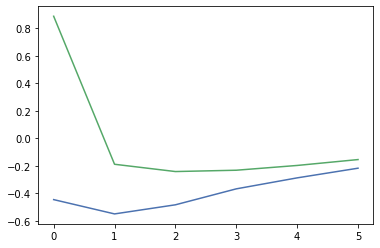

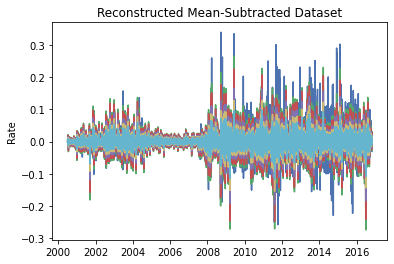

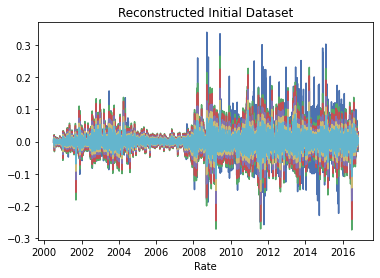

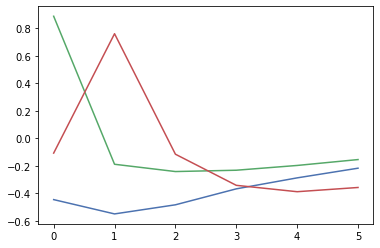

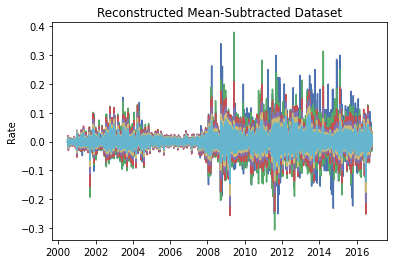

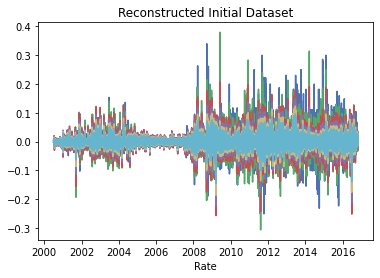

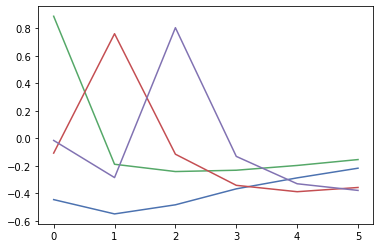

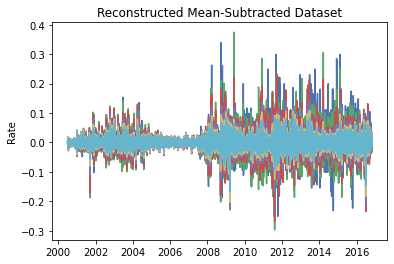

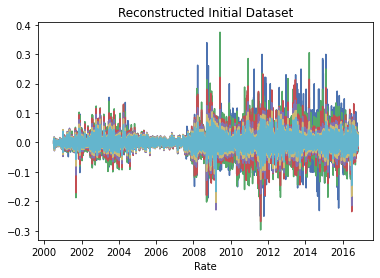

In [96]:
vec = [1,2,3,4]
comb_df = treasury_df2.merge(swap_df2, left_index=True, right_index=True)

for i in vec:
  scores, evals, evecs = mPCA(treasury_df3, i)
  evecs = pd.DataFrame(evecs)
  plt.plot(evecs)
  plt.show()
  reconst = pd.DataFrame(np.dot(scores,evecs.T), index=treasury_df3.index, columns=treasury_df3.columns)
  plt.plot(reconst)
  plt.ylabel("Rate")
  plt.title("Reconstructed Mean-Subtracted Dataset")
  plt.show()
  for cols in reconst.columns:
    reconst[cols] = reconst[cols] + treasury_df3.mean(axis=0)[cols]
  plt.plot(reconst)
  plt.xlabel("Rate")
  plt.title("Reconstructed Initial Dataset")
  plt.show()

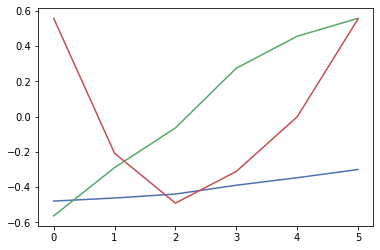

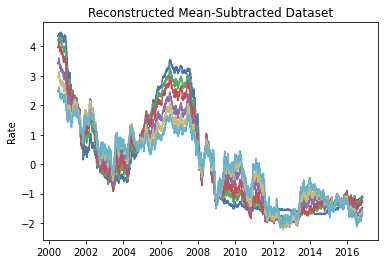

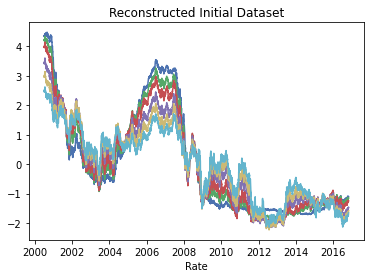

In [97]:
vec = 3
scores, evals, evecs = mPCA(treasury_df2, vec)
evecs = pd.DataFrame(evecs)
plt.plot(evecs)
plt.show()
reconst = pd.DataFrame(np.dot(scores,evecs.T), index=treasury_df2.index, columns=treasury_df2.columns)
plt.plot(reconst)
plt.ylabel("Rate")
plt.title("Reconstructed Mean-Subtracted Dataset")
plt.show()
for cols in reconst.columns:
  reconst[cols] = reconst[cols] + treasury_df2.mean(axis=0)[cols]
plt.plot(reconst)
plt.xlabel("Rate")
plt.title("Reconstructed Initial Dataset")
def PCA(df, num_reconstruct):
    
    df -= df.mean(axis=0)
    R = np.cov(df, rowvar=False)
    eigenvals, eigenvecs = sp.linalg.eigh(R)
    eigenvecs = eigenvecs[:, np.argsort(eigenvals)[::-1]]
    eigenvals = eigenvals[np.argsort(eigenvals)[::-1]]
    eigenvecs = eigenvecs[:, :num_reconstruct]

    return np.dot(eigenvecs.T, df.T).T, eigenvals, eigenvecsplt.show()

### PCA to Spread dataset


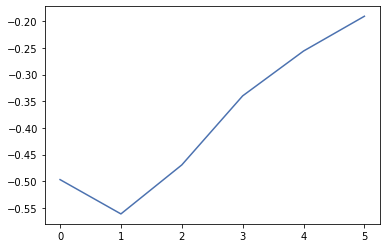

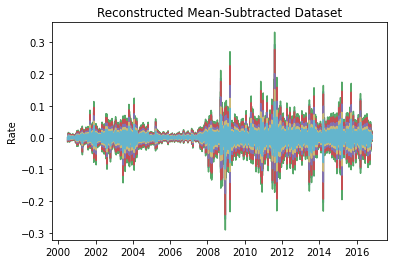

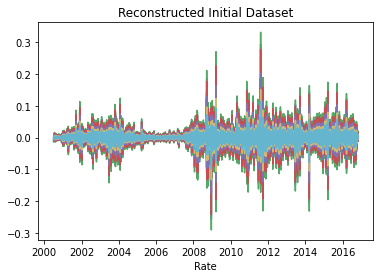

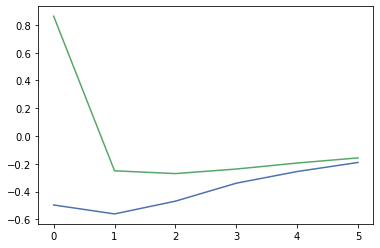

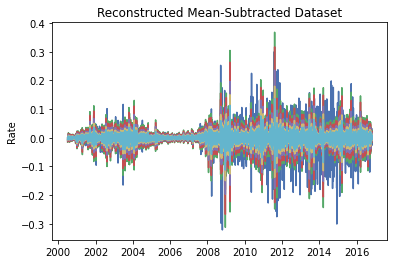

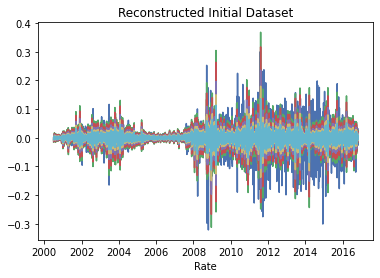

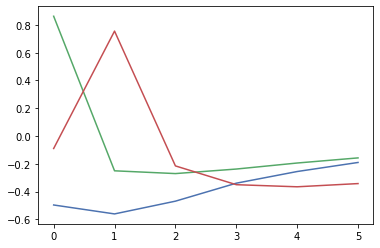

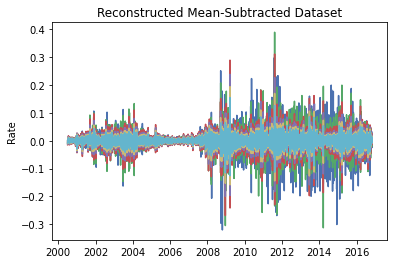

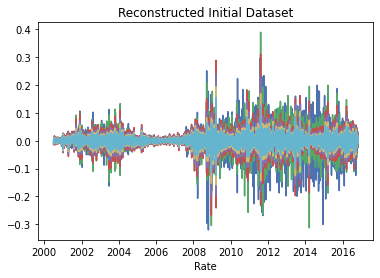

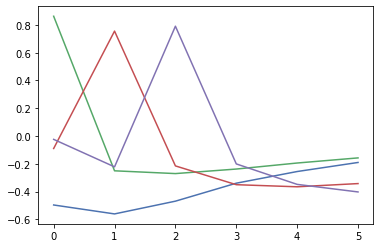

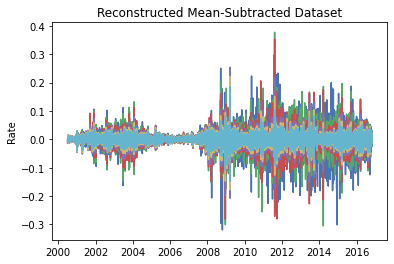

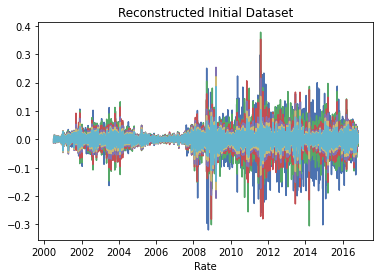

In [98]:
vec = [1,2,3,4]

for i in vec:
  scores, evals, evecs = mPCA(spread_df3, i)
  evecs = pd.DataFrame(evecs)
  plt.plot(evecs)
  plt.show()
  reconst = pd.DataFrame(np.dot(scores,evecs.T), index=spread_df3.index, columns=spread_df3.columns)
  plt.plot(reconst)
  plt.ylabel("Rate")
  plt.title("Reconstructed Mean-Subtracted Dataset")
  plt.show()
  for cols in reconst.columns:
    reconst[cols] = reconst[cols] + spread_df3.mean(axis=0)[cols]
  plt.plot(reconst)
  plt.xlabel("Rate")
  plt.title("Reconstructed Initial Dataset")
  plt.show()


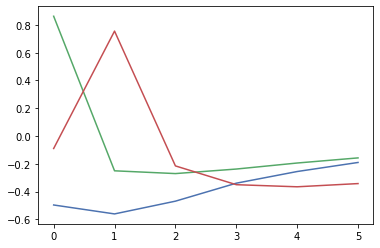

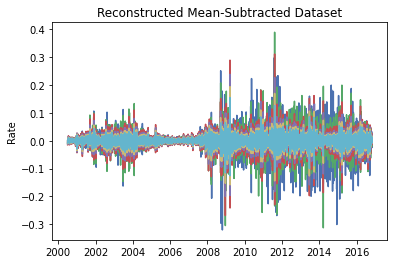

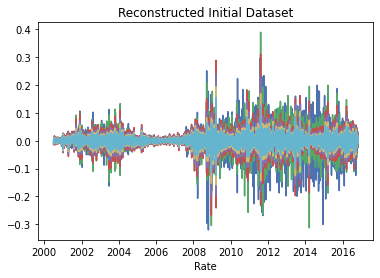

In [99]:
vec = 3
scores, evals, evecs = mPCA(spread_df3, vec)
evecs = pd.DataFrame(evecs)
plt.plot(evecs)
plt.show()
reconst = pd.DataFrame(np.dot(scores,evecs.T), index=spread_df3.index, columns=spread_df3.columns)
plt.plot(reconst)
plt.ylabel("Rate")
plt.title("Reconstructed Mean-Subtracted Dataset")
plt.show()
for cols in reconst.columns:
  reconst[cols] = reconst[cols] + spread_df3.mean(axis=0)[cols]
plt.plot(reconst)
plt.xlabel("Rate")
plt.title("Reconstructed Initial Dataset")
def PCA(df, num_reconstruct):
    
    df -= df.mean(axis=0)
    R = np.cov(df, rowvar=False)
    eigenvals, eigenvecs = sp.linalg.eigh(R)
    eigenvecs = eigenvecs[:, np.argsort(eigenvals)[::-1]]
    eigenvals = eigenvals[np.argsort(eigenvals)[::-1]]
    eigenvecs = eigenvecs[:, :num_reconstruct]

    return np.dot(eigenvecs.T, df.T).T, eigenvals, eigenvecsplt.show()

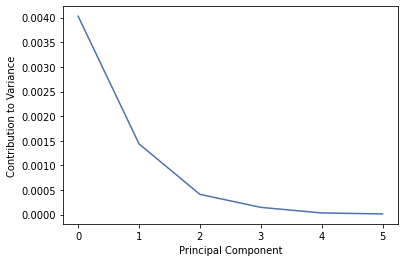

In [100]:
plt.plot(evals)
plt.ylabel("Contribution to Variance")
plt.xlabel("Principal Component")
plt.show()

## Step 10 - Reconstruction

### Defining PCABase

In [101]:
from sklearn.decomposition import PCA
class PCABase(object):
    def __init__(self, X, adjust_sign=True):
        self.X = X
        self.n_features = X.shape[1]
        self.dates = X.index
        self.Xc = self.X - self.X.mean()  # centered
        self.pc_names = lambda n: ['PC' + str(i) for i in np.arange(1, n + 1)]
        self.adjust_sign = adjust_sign


    def pca(self, n_pc=None):
        '''
        fit pca model
        n_pc: number of pcs to fit, take total feature numbers if not specified
        '''
        if n_pc:
            model = PCA(n_components=n_pc).fit(self.Xc)
        else:
            model = PCA().fit(self.Xc)
        return model

    def cps(self):
        '''
        loading matrix => principal axes in feature space
        '''
        cps = self.pca().components_.T
        cps = self.to_df_pc(cps, is_loading=True)
        if self.adjust_sign:
            cps.loc[:, 'PC1'] = np.sign(cps.loc[:, 'PC1'].values[0]) * cps.loc[:, 'PC1']
            cps.loc[:, 'PC2'] = -np.sign(cps.loc[:, 'PC2'].values[0]) * cps.loc[:, 'PC2']
        return cps

    def cumsum_expvar_ratio(self):
        var_exp = self.pca().explained_variance_ratio_
        var_exp_cumsum = np.cumsum(var_exp)
        return var_exp, var_exp_cumsum

    def scores(self):
        '''
        PC scores:
        '''
        scores = self.pca().transform(self.Xc)
        scores = self.to_df_pc(scores)
        if self.adjust_sign:
            cps = self.cps()
            scores.loc[:, 'PC1'] = np.sign(cps.loc[:, 'PC1'].values[0]) * scores.loc[:, 'PC1']
            scores.loc[:, 'PC2'] = -np.sign(cps.loc[:, 'PC2'].values[0]) * scores.loc[:, 'PC2']
        return scores

    def scores2(self):
        '''
        equivalent to the sklearn transform function
        '''
        scores = self.Xc.dot(self.cps())
        scores = self.to_df_pc(scores)
        if self.adjust_sign:
            cps = self.cps()
            scores.loc[:, 'PC1'] = np.sign(cps.loc[:, 'PC1'].values[0]) * scores.loc[:, 'PC1']
            scores.loc[:, 'PC2'] = -np.sign(cps.loc[:, 'PC2'].values[0]) * scores.loc[:, 'PC2']
        return scores

    def x_projected(self, p, centered=False):
        xp = self.scores().iloc[:, 0:p].dot(self.cps().T.iloc[0:p, :])
        if not centered:
            xp = xp + self.X.mean()
        return xp

    def residuals(self, p):
        residuals = self.X - self.x_projected(p, centered=False)
        return residuals

    def covX(self):
        return self.X.cov()

    def eigenv(self):
        eig_vals, eig_vecs = np.linalg.eig(self.covX())
        return eig_vals, eig_vecs

    def to_df_pc(self, data, is_loading=False):
        cols = self.pc_names(self.n_features)
        idx = self.X.columns if is_loading else self.dates
        return pd.DataFrame(data, columns=cols, index=idx)

### Reconstructing Swap Dataset

In [102]:
pcab_w = PCABase(swap_df2)

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
SWAP1   0.398272 -0.582862 -0.547360  0.370237 -0.243813 -0.068998 -0.019578   
SWAP2   0.394477 -0.330765  0.014223 -0.446503  0.597824  0.365376  0.140462   
SWAP3   0.385068 -0.125279  0.303352 -0.349773 -0.074967 -0.496320 -0.357805   
SWAP4   0.371299  0.024636  0.369450 -0.053749 -0.371393 -0.218919  0.154742   
SWAP5   0.356508  0.136138  0.316726  0.189746 -0.297502  0.462132  0.460620   
SWAP7   0.330307  0.279021  0.121841  0.402599  0.162362  0.332227 -0.695932   
SWAP10  0.304863  0.391045 -0.131666  0.349759  0.500787 -0.481943  0.359985   
SWAP30  0.265490  0.534100 -0.582394 -0.466807 -0.271942  0.106162 -0.042853   

             PC8  
SWAP1   0.019591  
SWAP2  -0.157458  
SWAP3   0.491616  
SWAP4  -0.715783  
SWAP5   0.451448  
SWAP7  -0.122704  
SWAP10  0.042762  
SWAP30 -0.010081

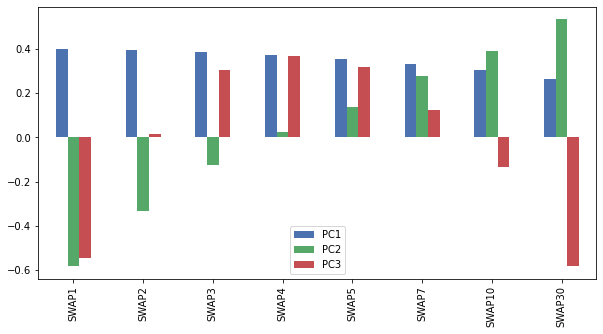

In [103]:
V = pd.DataFrame(pcab_w.pca().components_,index=pcab_w.pc_names(pcab_w.n_features),columns=pcab_w.X.columns)
V.T.iloc[:,0:3].plot(figsize=(10,5),kind='bar')
pcab_w.cps()

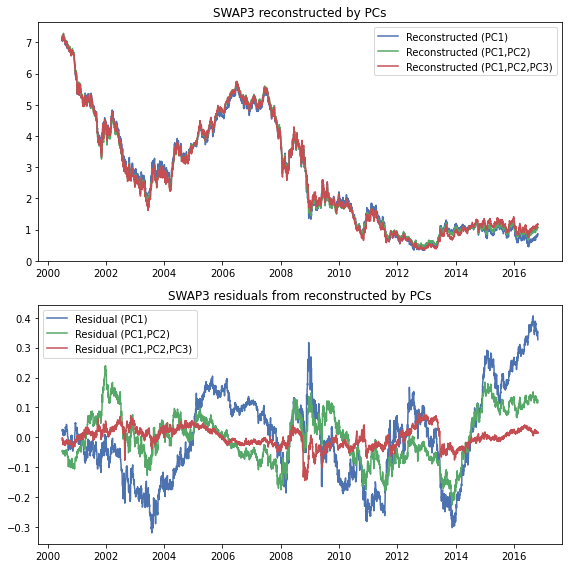

In [104]:
r = 'SWAP3'
fig,(ax,ax2)=plt.subplots(figsize=(8,4*2),ncols=1,nrows=2)
ax.plot(pcab_w.x_projected(1)[r])
ax.plot(pcab_w.x_projected(2)[r])
ax.plot(pcab_w.x_projected(3)[r])
ax.legend(['Reconstructed (PC1)','Reconstructed (PC1,PC2)','Reconstructed (PC1,PC2,PC3)'])
ax.set_title('{} reconstructed by PCs'.format(r))

ax2.plot(pcab_w.residuals(1)[r])
ax2.plot(pcab_w.residuals(2)[r])
ax2.plot(pcab_w.residuals(3)[r])
ax2.legend(['Residual (PC1)','Residual (PC1,PC2)','Residual (PC1,PC2,PC3)'])
ax2.set_title('{} residuals from reconstructed by PCs'.format(r))
fig.tight_layout()

Text(0.5, 1.0, 'Evolution of PCA Factors 1,2,3')

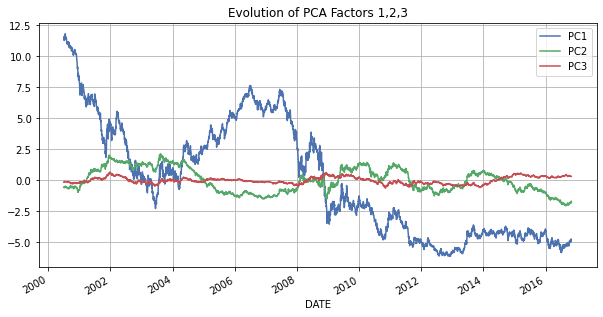

In [105]:
# PC
fig,ax=plt.subplots(figsize=(10,5))
l1=pcab_w.scores().iloc[:,0:3].plot(ax=ax)
ax.grid(True)
ax.set_title('Evolution of PCA Factors 1,2,3')

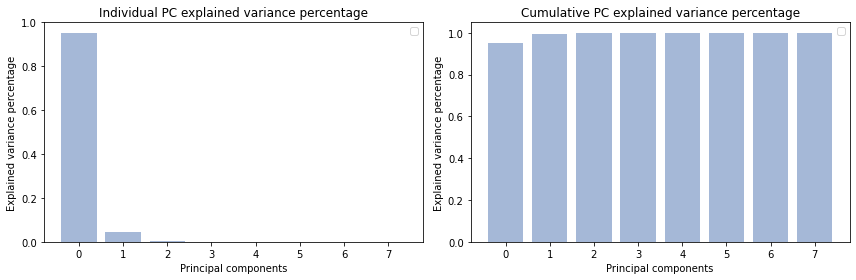

In [106]:
fig,(ax,ax2) = plt.subplots(figsize=(6*2, 4),ncols=2,nrows=1)
ax.bar(range(pcab_w.n_features), pcab_w.cumsum_expvar_ratio()[0], alpha=0.5, align='center')
ax2.bar(range(pcab_w.n_features), pcab_w.cumsum_expvar_ratio()[1], alpha=0.5, align='center')
ax.set_ylabel('Explained variance percentage')
ax.set_xlabel('Principal components')
ax.set_title('Individual PC explained variance percentage')
ax.legend(loc='best')
ax2.set_ylabel('Explained variance percentage')
ax2.set_xlabel('Principal components')
ax2.set_title('Cumulative PC explained variance percentage')
ax2.legend(loc='best')
fig.tight_layout()

### Reconstructing Treasury Dataset

In [107]:
pcab_t = PCABase(treasury_df2)

PC1       PC2       PC3       PC4       PC5       PC6
TRESY1y   0.479728 -0.563857 -0.558017 -0.345562  0.083152 -0.119234
TRESY2y   0.462331 -0.289788  0.208138  0.515223 -0.325826  0.536036
TRESY3y   0.439788 -0.064255  0.491276  0.202977  0.158912 -0.703316
TRESY5y   0.389733  0.274420  0.311471 -0.428211  0.549268  0.436723
TRESY7y   0.347105  0.455778  0.001501 -0.400461 -0.708226 -0.099139
TRESY10y  0.300539  0.557601 -0.554010  0.479790  0.241641 -0.056932

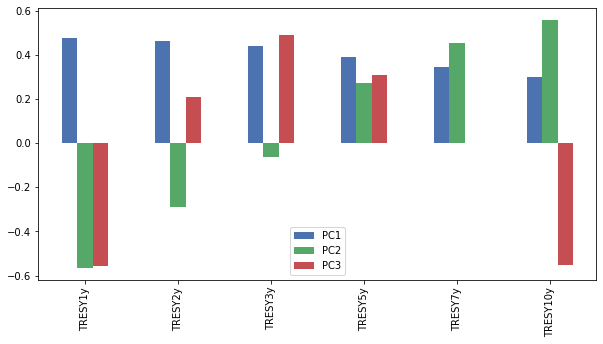

In [108]:
V = pd.DataFrame(pcab_t.pca().components_,index=pcab_t.pc_names(pcab_t.n_features),columns=pcab_t.X.columns)
V.T.iloc[:,0:3].plot(figsize=(10,5),kind='bar')
pcab_t.cps()

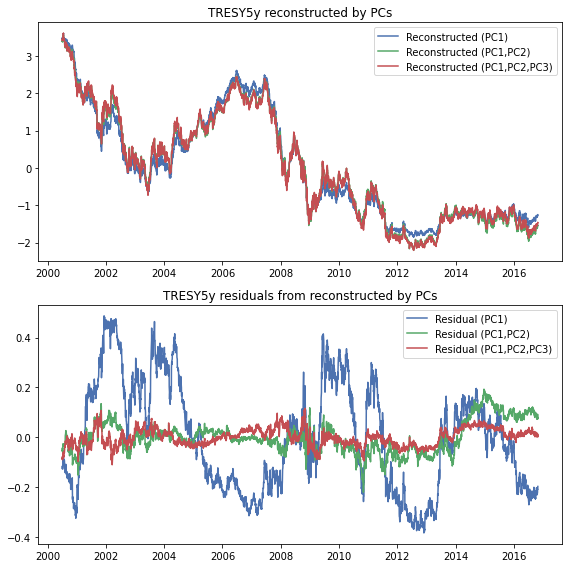

In [109]:
r = 'TRESY5y'
fig,(ax,ax2)=plt.subplots(figsize=(8,4*2),ncols=1,nrows=2)
ax.plot(pcab_t.x_projected(1)[r])
ax.plot(pcab_t.x_projected(2)[r])
ax.plot(pcab_t.x_projected(3)[r])
ax.legend(['Reconstructed (PC1)','Reconstructed (PC1,PC2)','Reconstructed (PC1,PC2,PC3)'])
ax.set_title('{} reconstructed by PCs'.format(r))

ax2.plot(pcab_t.residuals(1)[r])
ax2.plot(pcab_t.residuals(2)[r])
ax2.plot(pcab_t.residuals(3)[r])
ax2.legend(['Residual (PC1)','Residual (PC1,PC2)','Residual (PC1,PC2,PC3)'])
ax2.set_title('{} residuals from reconstructed by PCs'.format(r))
fig.tight_layout()

Text(0.5, 1.0, 'Evolution of PCA Factors 1,2,3')

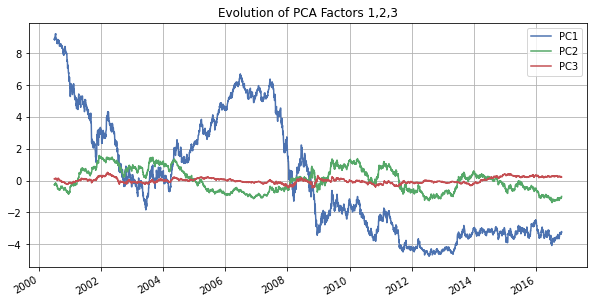

In [110]:
# PC
fig,ax=plt.subplots(figsize=(10,5))
l1=pcab_t.scores().iloc[:,0:3].plot(ax=ax)
ax.grid(True)
ax.set_title('Evolution of PCA Factors 1,2,3')

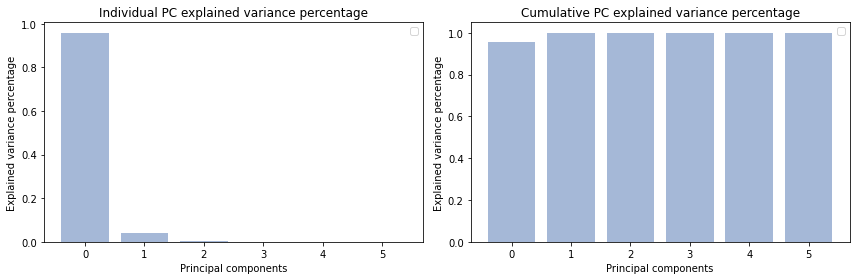

In [111]:
fig,(ax,ax2) = plt.subplots(figsize=(6*2, 4),ncols=2,nrows=1)
ax.bar(range(pcab_t.n_features), pcab_t.cumsum_expvar_ratio()[0], alpha=0.5, align='center')
ax2.bar(range(pcab_t.n_features), pcab_t.cumsum_expvar_ratio()[1], alpha=0.5, align='center')
ax.set_ylabel('Explained variance percentage')
ax.set_xlabel('Principal components')
ax.set_title('Individual PC explained variance percentage')
ax.legend(loc='best')
ax2.set_ylabel('Explained variance percentage')
ax2.set_xlabel('Principal components')
ax2.set_title('Cumulative PC explained variance percentage')
ax2.legend(loc='best')
fig.tight_layout()

### Reconstructing Spread Dataset

In [112]:
pcab_r = PCABase(spread_df2)

PC1       PC2       PC3       PC4       PC5       PC6  \
SPREAD1y   0.011553 -0.282915  0.740507 -0.548913  0.005091  0.140456   
SPREAD2y   0.013114 -0.331625  0.345822  0.249008 -0.253541 -0.380429   
SPREAD3y   0.015406 -0.383154  0.140770  0.614647 -0.284398 -0.073886   
SPREAD5y   0.013584 -0.429418 -0.062139  0.231233  0.275278  0.781743   
SPREAD7y   0.009865 -0.472388 -0.184984 -0.078017  0.712353 -0.467934   
SPREAD10y  0.005016 -0.504897 -0.523508 -0.446430 -0.521138  0.000088   
^VIX       0.999575  0.026557 -0.009968 -0.006528 -0.000505 -0.001499   

                PC7  
SPREAD1y   0.224533  
SPREAD2y  -0.706573  
SPREAD3y   0.607459  
SPREAD5y  -0.266806  
SPREAD7y   0.100190  
SPREAD10y  0.010464  
^VIX      -0.000103

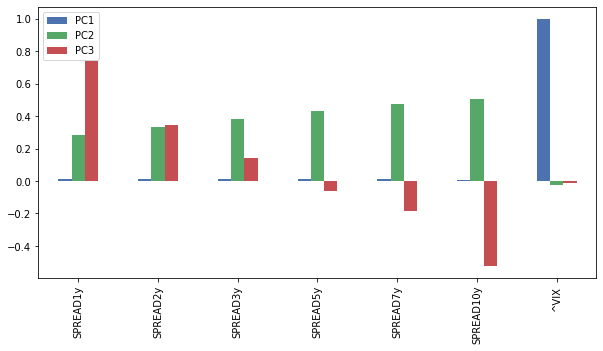

In [113]:
V = pd.DataFrame(pcab_r.pca().components_,index=pcab_r.pc_names(pcab_r.n_features),columns=pcab_r.X.columns)
V.T.iloc[:,0:3].plot(figsize=(10,5),kind='bar')
pcab_r.cps()

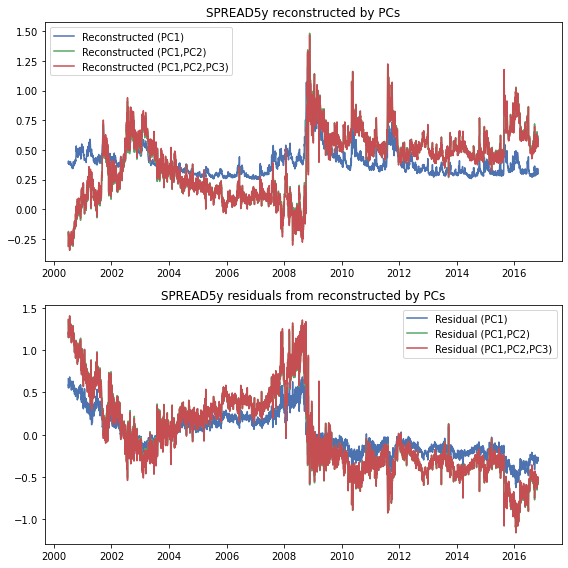

In [114]:
r = 'SPREAD5y'
fig,(ax,ax2)=plt.subplots(figsize=(8,4*2),ncols=1,nrows=2)
ax.plot(pcab_r.x_projected(1)[r])
ax.plot(pcab_r.x_projected(2)[r])
ax.plot(pcab_r.x_projected(3)[r])
ax.legend(['Reconstructed (PC1)','Reconstructed (PC1,PC2)','Reconstructed (PC1,PC2,PC3)'])
ax.set_title('{} reconstructed by PCs'.format(r))

ax2.plot(pcab_r.residuals(1)[r])
ax2.plot(pcab_r.residuals(2)[r])
ax2.plot(pcab_r.residuals(3)[r])
ax2.legend(['Residual (PC1)','Residual (PC1,PC2)','Residual (PC1,PC2,PC3)'])
ax2.set_title('{} residuals from reconstructed by PCs'.format(r))
fig.tight_layout()

Text(0.5, 1.0, 'Evolution of PCA Factors 1,2,3')

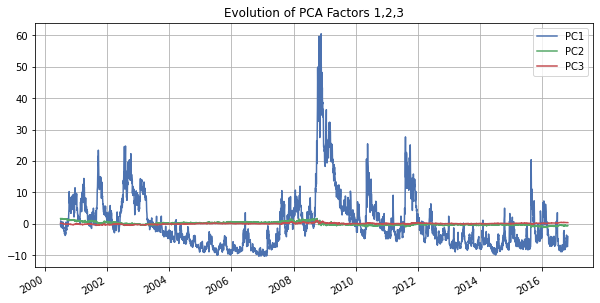

In [115]:
# PC
fig,ax=plt.subplots(figsize=(10,5))
l1=pcab_r.scores().iloc[:,0:3].plot(ax=ax)
ax.grid(True)
ax.set_title('Evolution of PCA Factors 1,2,3')

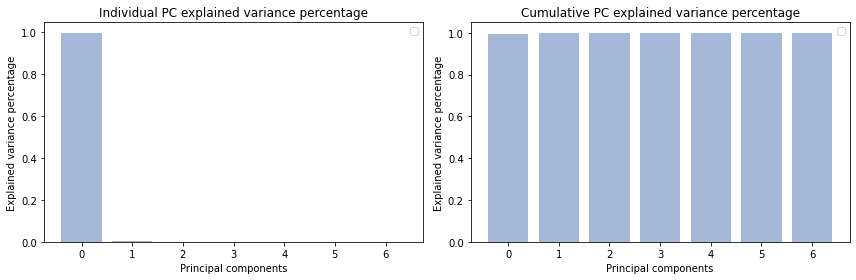

In [116]:
fig,(ax,ax2) = plt.subplots(figsize=(6*2, 4),ncols=2,nrows=1)
ax.bar(range(pcab_r.n_features), pcab_r.cumsum_expvar_ratio()[0], alpha=0.5, align='center')
ax2.bar(range(pcab_r.n_features), pcab_r.cumsum_expvar_ratio()[1], alpha=0.5, align='center')
ax.set_ylabel('Explained variance percentage')
ax.set_xlabel('Principal components')
ax.set_title('Individual PC explained variance percentage')
ax.legend(loc='best')
ax2.set_ylabel('Explained variance percentage')
ax2.set_xlabel('Principal components')
ax2.set_title('Cumulative PC explained variance percentage')
ax2.legend(loc='best')
fig.tight_layout()

## Step 11 - Applying Clustering

### Clustering Function

In [117]:
from sklearn.cluster import KMeans
def model_kmeans(data,n_clusters=3,init_method = 'k-means++',n_init=10):
  model = KMeans(n_clusters=n_clusters,
                  init=init_method,
                  n_init=n_init)
  model.fit(data)
  cluster_labels = model.predict(data)
  cluster_centers = model.cluster_centers_
  fit_res = {'cluster_method':'kmeans',
              'model':model,
              'cluster_labels':cluster_labels,
              'cluster_centers':cluster_centers,
              'data':data}
  return fit_res

### To Swap Data

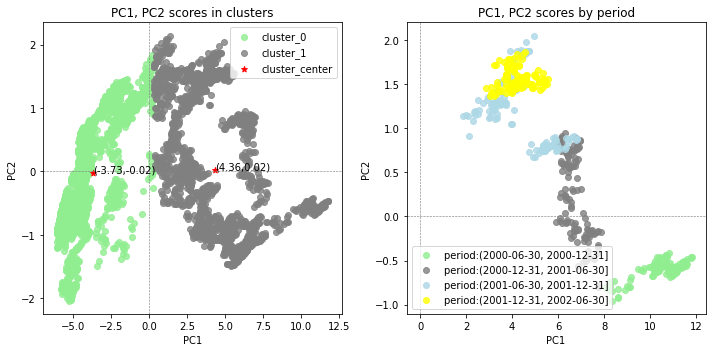

In [118]:
s_w = pcab_w.scores()[['PC1','PC2']]
kmeans = model_kmeans(s_w,n_clusters=2)  
X = s_w.reset_index()
X = X.rename(columns={'DATE':'date'})

feature_pair = ['PC1','PC2']
fig,(ax,ax2)=plt.subplots(ncols=2,nrows=1,figsize=(10,5))
cluster_labels = kmeans['cluster_labels']
X['cluster_label'] = cluster_labels
cluster_centers = kmeans['cluster_centers']
mode_fitted = kmeans['model']
label_order = sorted(list(set(cluster_labels)))
colors = ['lightgreen','grey','lightblue','yellow']
# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, [1,2,5,10])]
color_map_clusters = dict(zip(label_order, colors))
for (c_label,color) in color_map_clusters.items():
  x = X[X['cluster_label']==c_label][feature_pair[0]]
  y = X[X['cluster_label']==c_label][feature_pair[1]]
  ax.scatter(x,y,c=color,alpha=0.8)
ax.legend()
ax.scatter(cluster_centers[:,0],cluster_centers[:,1],c='red',marker='*')
# add cluster center annotion
for xy in tuple(np.round(cluster_centers,2)):
  ax.annotate("({},{})".format(xy[0],xy[1]),xy=(xy[0],xy[1]))
ax.set_xlabel(feature_pair[0])
ax.set_ylabel(feature_pair[1])
ax.legend(['cluster_{}'.format(c) for c in set(cluster_labels)]+['cluster_center'])
ax.set_title('PC1, PC2 scores in clusters')
ax.axhline(y=0,ls='--',color='grey',linewidth=0.6)
ax.axvline(x=0,ls='--',color='grey',linewidth=0.6)
# 
X['date'] = pd.to_datetime(X['date'])
periods = pd.date_range(X['date'].iloc[0]-pd.Timedelta(days=3),X['date'].iloc[-1],freq='6M')
X['date_bucket'] = pd.cut(X['date'],bins=periods)
color_map_periods = dict(zip(X['date_bucket'].unique(), colors))
for (p_label,color) in color_map_periods.items():
  x = X[X['date_bucket']==p_label][feature_pair[0]]
  y = X[X['date_bucket']==p_label][feature_pair[1]]
  ax2.scatter(x,y,c=color,alpha=0.8)
ax2.legend()

ax2.set_xlabel(feature_pair[0])
ax2.set_ylabel(feature_pair[1])
ax2.set_title('PC1, PC2 scores by period')
ax2.legend(['period:{}'.format(c) for c in X['date_bucket'].unique()])
ax2.axhline(y=0,ls='--',color='grey',linewidth=0.6)
ax2.axvline(x=0,ls='--',color='grey',linewidth=0.6)
fig.tight_layout()

### To Treasury data

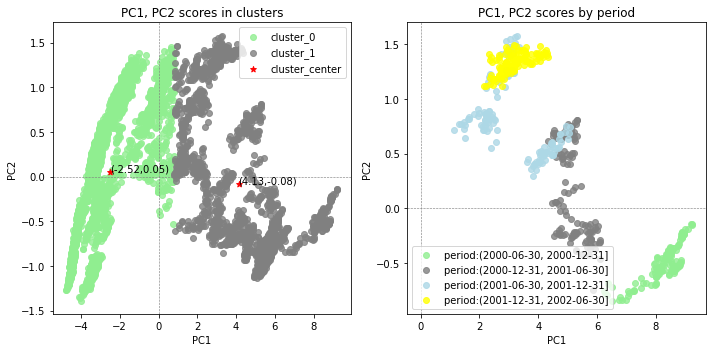

In [119]:
s_t = pcab_t.scores()[['PC1','PC2']]
kmeans = model_kmeans(s_t,n_clusters=2)  
X = s_t.reset_index()
X = X.rename(columns={'Date':'date'})

feature_pair = ['PC1','PC2']
fig,(ax,ax2)=plt.subplots(ncols=2,nrows=1,figsize=(10,5))
cluster_labels = kmeans['cluster_labels']
X['cluster_label'] = cluster_labels
cluster_centers = kmeans['cluster_centers']
mode_fitted = kmeans['model']
label_order = sorted(list(set(cluster_labels)))
colors = ['lightgreen','grey','lightblue','yellow']
color_map_clusters = dict(zip(label_order, colors))
for (c_label,color) in color_map_clusters.items():
  x = X[X['cluster_label']==c_label][feature_pair[0]]
  y = X[X['cluster_label']==c_label][feature_pair[1]]
  ax.scatter(x,y,c=color,alpha=0.8)
ax.legend()
ax.scatter(cluster_centers[:,0],cluster_centers[:,1],c='red',marker='*')
# add cluster center annotion
for xy in tuple(np.round(cluster_centers,2)):
  ax.annotate("({},{})".format(xy[0],xy[1]),xy=(xy[0],xy[1]))
ax.set_xlabel(feature_pair[0])
ax.set_ylabel(feature_pair[1])
ax.legend(['cluster_{}'.format(c) for c in set(cluster_labels)]+['cluster_center'])
ax.set_title('PC1, PC2 scores in clusters')
ax.axhline(y=0,ls='--',color='grey',linewidth=0.6)
ax.axvline(x=0,ls='--',color='grey',linewidth=0.6)
# 
X['date'] = pd.to_datetime(X['index'])
periods = pd.date_range(X['date'].iloc[0]-pd.Timedelta(days=3),X['date'].iloc[-1],freq='6M')
X['date_bucket'] = pd.cut(X['date'],bins=periods)
color_map_periods = dict(zip(X['date_bucket'].unique(), colors))
for (p_label,color) in color_map_periods.items():
  x = X[X['date_bucket']==p_label][feature_pair[0]]
  y = X[X['date_bucket']==p_label][feature_pair[1]]
  ax2.scatter(x,y,c=color,alpha=0.8)
ax2.legend()

ax2.set_xlabel(feature_pair[0])
ax2.set_ylabel(feature_pair[1])
ax2.set_title('PC1, PC2 scores by period')
ax2.legend(['period:{}'.format(c) for c in X['date_bucket'].unique()], loc='lower left')
ax2.axhline(y=0,ls='--',color='grey',linewidth=0.6)
ax2.axvline(x=0,ls='--',color='grey',linewidth=0.6)
fig.tight_layout()

### To Spread data

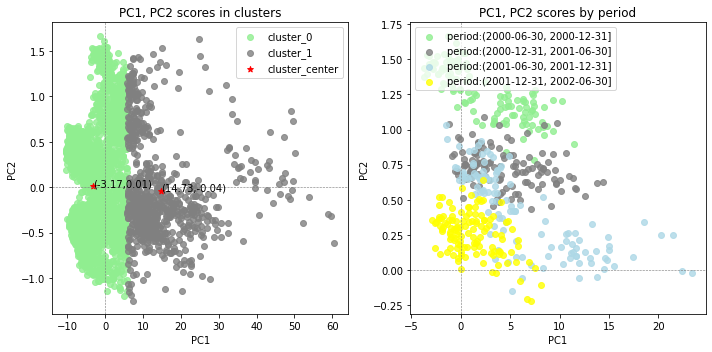

In [121]:
s_r = pcab_r.scores()[['PC1','PC2']]
kmeans = model_kmeans(s_r,n_clusters=2)  
X = s_r.reset_index()
X = X.rename(columns={'index':'date'})

feature_pair = ['PC1','PC2']
fig,(ax,ax2)=plt.subplots(ncols=2,nrows=1,figsize=(10,5))
cluster_labels = kmeans['cluster_labels']
X['cluster_label'] = cluster_labels
cluster_centers = kmeans['cluster_centers']
mode_fitted = kmeans['model']
label_order = sorted(list(set(cluster_labels)))
colors = ['lightgreen','grey','lightblue','yellow']
color_map_clusters = dict(zip(label_order, colors))
for (c_label,color) in color_map_clusters.items():
  x = X[X['cluster_label']==c_label][feature_pair[0]]
  y = X[X['cluster_label']==c_label][feature_pair[1]]
  ax.scatter(x,y,c=color,alpha=0.8)
ax.legend()
ax.scatter(cluster_centers[:,0],cluster_centers[:,1],c='red',marker='*')
# add cluster center annotion
for xy in tuple(np.round(cluster_centers,2)):
  ax.annotate("({},{})".format(xy[0],xy[1]),xy=(xy[0],xy[1]))
ax.set_xlabel(feature_pair[0])
ax.set_ylabel(feature_pair[1])
ax.legend(['cluster_{}'.format(c) for c in set(cluster_labels)]+['cluster_center'])
ax.set_title('PC1, PC2 scores in clusters')
ax.axhline(y=0,ls='--',color='grey',linewidth=0.6)
ax.axvline(x=0,ls='--',color='grey',linewidth=0.6)
# 
X['date'] = pd.to_datetime(X['date'])
periods = pd.date_range(X['date'].iloc[0]-pd.Timedelta(days=3),X['date'].iloc[-1],freq='6M')
X['date_bucket'] = pd.cut(X['date'],bins=periods)
color_map_periods = dict(zip(X['date_bucket'].unique(), colors))
for (p_label,color) in color_map_periods.items():
  x = X[X['date_bucket']==p_label][feature_pair[0]]
  y = X[X['date_bucket']==p_label][feature_pair[1]]
  ax2.scatter(x,y,c=color,alpha=0.8)
ax2.legend()

ax2.set_xlabel(feature_pair[0])
ax2.set_ylabel(feature_pair[1])
ax2.set_title('PC1, PC2 scores by period')
ax2.legend(['period:{}'.format(c) for c in X['date_bucket'].unique()], loc='upper left')
ax2.axhline(y=0,ls='--',color='grey',linewidth=0.6)
ax2.axvline(x=0,ls='--',color='grey',linewidth=0.6)
fig.tight_layout()

## Step 12 - Rates Simulation

Interest rates demonstrate the mean reversion property first articulated by Vasicek and later extended by Hull and White. We use the original Vasicek short-rate model to simulate spreads. 

$$ dr_t = κ(θ − r_t)dt + σdW $$

where κ represents the mean reversion strength, θ is the long-run mean and σ  is the volatility.

To calibrate the model to the real world (i.e. we use historical data) we apply the MLE to the sread data. 

Interest rate paths are simulated with the Monte Carlo approach applied to the closed form solution. 

$$r_{t_i} = r_{t_i}{exp}(−κ(t_i−t_{i−1}))+θ(1 − {exp}(−κ(t_i−t_{i−1})))+Z√{{σ^2(1−exp(−2κ(t_i−t_{i−1})))}/{2κ}}$$

where $$Z : N(0,1)$$

### Defining functions

In [122]:
#The closed form solution for the Vasicek Model
def NextRate(r, kappa, theta, sigma, dt=1/252):

    val1 = np.exp(-1*kappa*dt)
    val2 = (sigma**2)*(1-val1**2) / (2*kappa)
    out = r*val1 + theta*(1-val1) + (np.sqrt(val2))*np.random.normal()
    return out

In [123]:
#Rates simulation based on the closed form solution for the Vasicek Model
def Sim(N, r0, kappa, theta, sigma, dt = 1/252):
    short_r = [0]*N
    short_r[0] = r0
    for i in range(1,N):
        short_r[i] = NextRate(short_r[i-1], kappa, theta, sigma, dt)
    
    return short_r

In [124]:
#Simulation for M rate curves
def MultiSim(M, N, r0, kappa, theta, sigma, dt = 1/252):
    sim_arr = np.ndarray((N, M))
    
    for i in range(0,M):
        sim_arr[:, i] = Sim(N, r0, kappa, theta, sigma, dt)
    
    return sim_arr

In [125]:
def Calibration(rates, dt=1/252):
    n = len(rates)
    
    Sx = sum(rates[0:(n-1)])
    Sy = sum(rates[1:n])
    Sxx = np.dot(rates[0:(n-1)], rates[0:(n-1)])
    Sxy = np.dot(rates[0:(n-1)], rates[1:n])
    Syy = np.dot(rates[1:n], rates[1:n])
    
    theta = (Sy * Sxx - Sx * Sxy) / (n * (Sxx - Sxy) - (Sx**2 - Sx*Sy))
    kappa = -np.log((Sxy - theta * Sx - theta * Sy + n * theta**2) / (Sxx - 2*theta*Sx + n*theta**2)) / dt
    a = np.exp(-kappa * dt)
    sigmah2 = (Syy - 2*a*Sxy + a**2 * Sxx - 2*theta*(1-a)*(Sy - a*Sx) + n*theta**2 * (1-a)**2) / n
    sigma = np.sqrt(sigmah2*2*kappa / (1-a**2))
    r0 = rates[n-1]
    
    return [kappa, theta, sigma, r0]

### Model Calibration

In [126]:
swp_cols = ["SWAP1","SWAP2","SWAP3","SWAP5","SWAP7","SWAP10"]
tres_cols = ['TRESY1y','TRESY2y','TRESY3y','TRESY5y','TRESY7y','TRESY10y']
mat_cols = ["DGS1","DGS2","DGS5","DGS7","DGS10"]
spr_cols = ["SPREAD1y", "SPREAD2y", "SPREAD3y", "SPREAD5y", "SPREAD7y", "SPREAD10y"]

#### For Swap Data

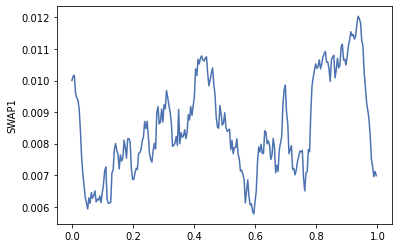

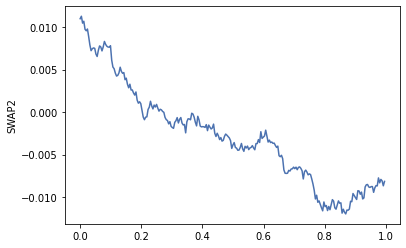

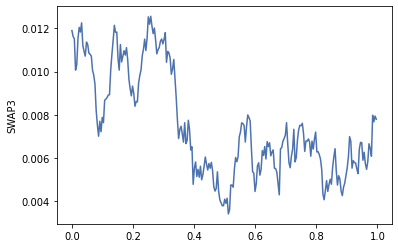

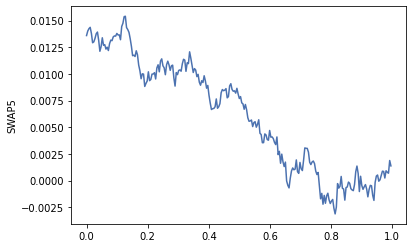

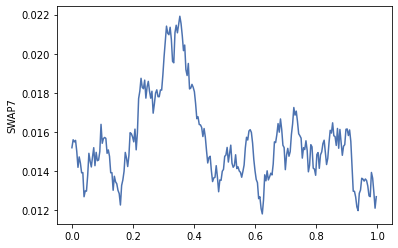

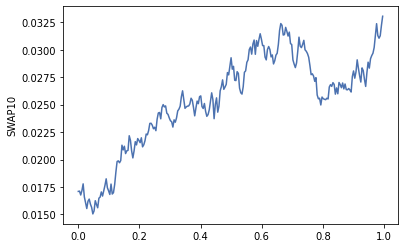

In [127]:
for i in swp_cols:
  params = Calibration(swap_df.loc[:, i].dropna()/100)
  kappa = params[0]
  theta = params[1]
  sigma = params[2]
  r0 = params[3]
  years = 1
  N = years * 252
  t = np.arange(0,N)/252
  test_sim = Sim(N, r0, kappa, theta, sigma, 1/252)
  plt.plot(t,test_sim)
  plt.ylabel(i)
  plt.show()

#### For Treasury Data

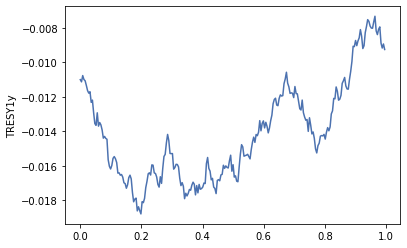

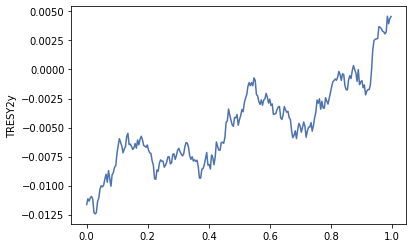

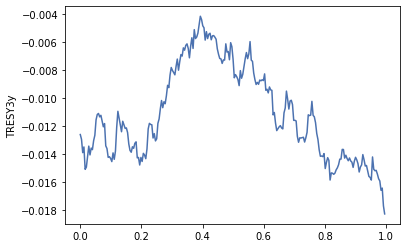

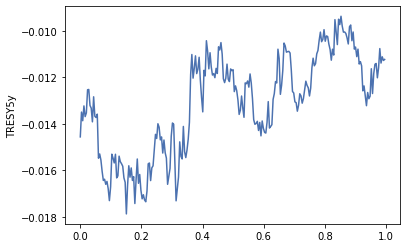

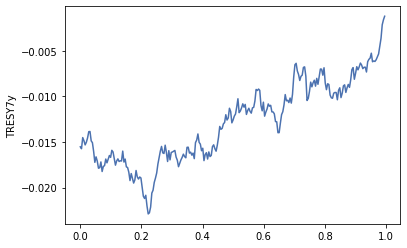

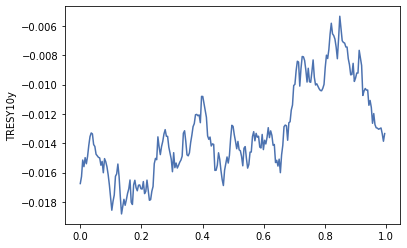

In [128]:
for i in tres_cols:
  params = Calibration(treasury_df2.loc[:, i].dropna()/100)
  kappa = params[0]
  theta = params[1]
  sigma = params[2]
  r0 = params[3]
  years = 1
  N = years * 252
  t = np.arange(0,N)/252
  test_sim = Sim(N, r0, kappa, theta, sigma, 1/252)
  plt.plot(t,test_sim)
  plt.ylabel(i)
  plt.show()

#### For Spread Data

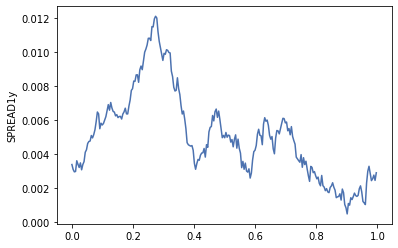

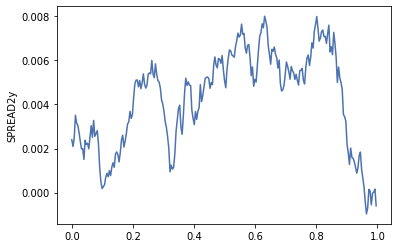

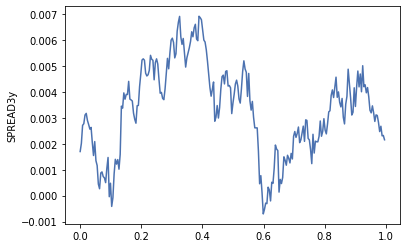

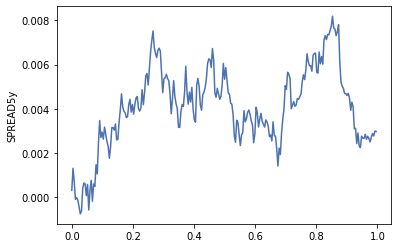

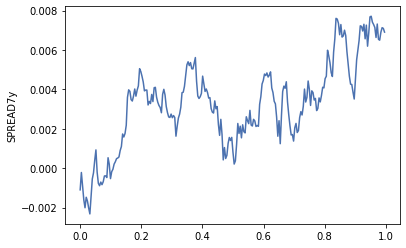

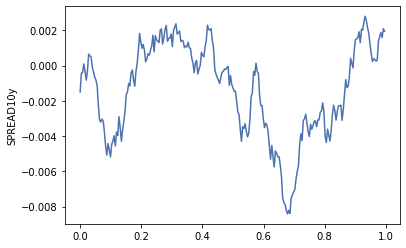

In [129]:
for i in spr_cols:
  params = Calibration(spread_df.loc[:, i].dropna()/100)
  kappa = params[0]
  theta = params[1]
  sigma = params[2]
  r0 = params[3]
  years = 1
  N = years * 252
  t = np.arange(0,N)/252
  test_sim = Sim(N, r0, kappa, theta, sigma, 1/252)
  plt.plot(t,test_sim)
  plt.ylabel(i)
  plt.show()

### Rates Simulation - I

The simulation starts with r0 (initial rate value) equals to last observed rate value.

#### For Swap Data

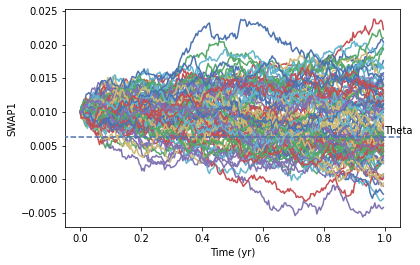

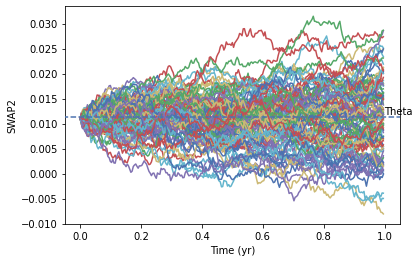

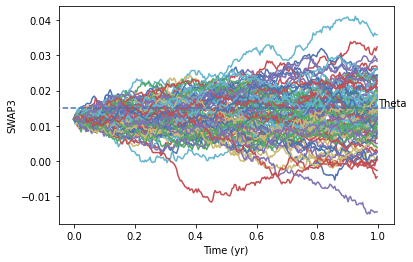

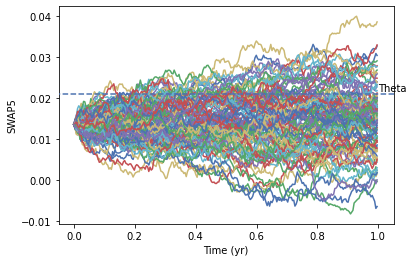

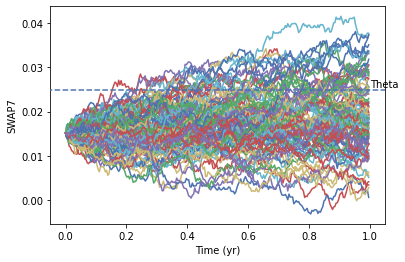

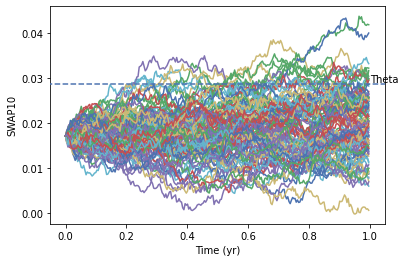

In [130]:
 for i in swp_cols:
   params = Calibration(swap_df.loc[:, i].dropna()/100)
   kappa = params[0]
   theta = params[1]
   sigma = params[2]
   r0 = params[3]

   years = 1
   N = years * 252
   t = np.arange(0,N)/252
   M = 100
   rates_arr = MultiSim(M, N, r0, kappa, theta, sigma)

   plt.plot(t,rates_arr)

   plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
   plt.annotate('Theta', xy=(1.0, theta+0.0005))
   plt.xlim(-0.05, 1.05)

   plt.ylabel(i)
   plt.xlabel("Time (yr)")
   plt.show()

#### For Treasury Data

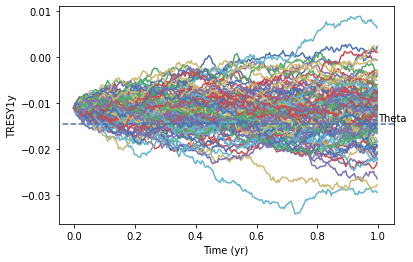

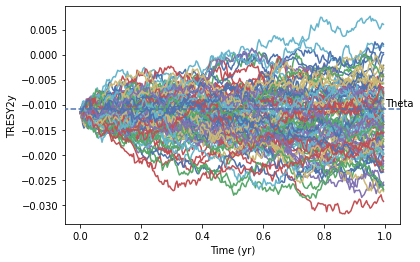

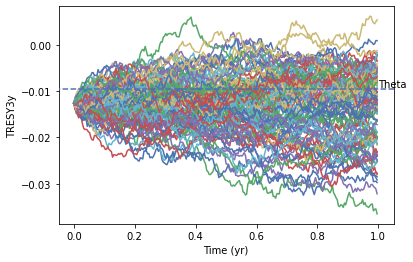

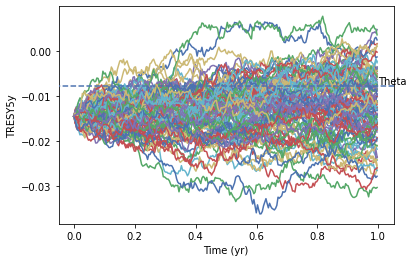

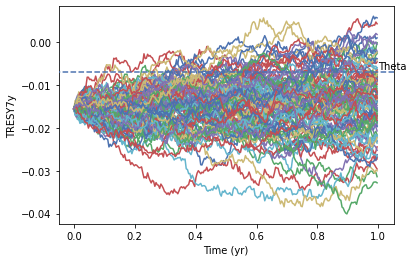

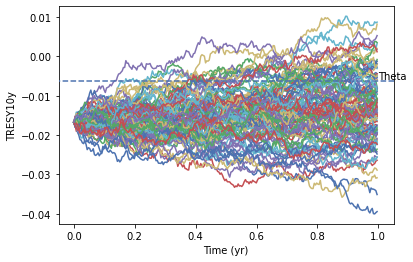

In [131]:
 for i in tres_cols:
   params = Calibration(treasury_df2.loc[:, i].dropna()/100)
   kappa = params[0]
   theta = params[1]
   sigma = params[2]
   r0 = params[3]

   years = 1
   N = years * 252
   t = np.arange(0,N)/252
   M = 100
   rates_arr = MultiSim(M, N, r0, kappa, theta, sigma)

   plt.plot(t,rates_arr)

   plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
   plt.annotate('Theta', xy=(1.0, theta+0.0005))
   plt.xlim(-0.05, 1.05)

   plt.ylabel(i)
   plt.xlabel("Time (yr)")
   plt.show()

#### For Spread Data

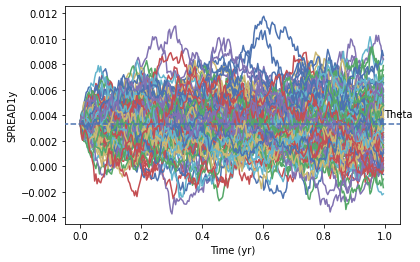

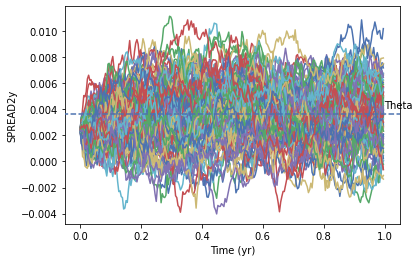

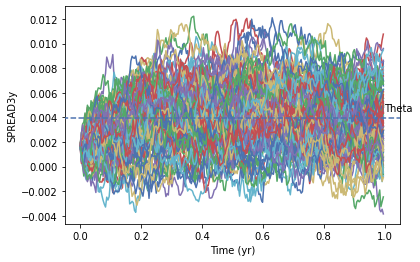

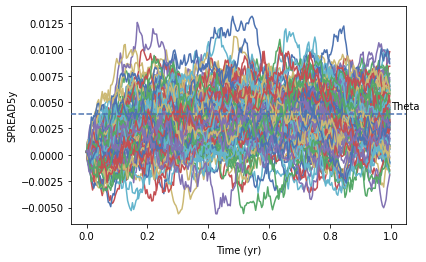

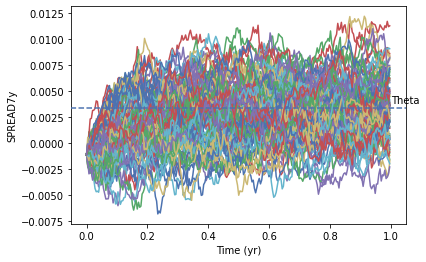

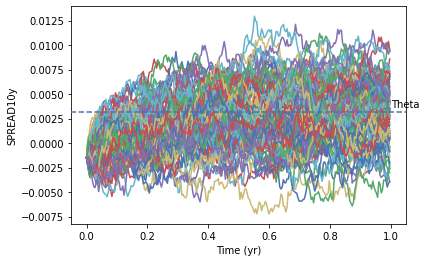

In [132]:
 for i in spr_cols:
   params = Calibration(spread_df.loc[:, i].dropna()/100)
   kappa = params[0]
   theta = params[1]
   sigma = params[2]
   r0 = params[3]

   years = 1
   N = years * 252
   t = np.arange(0,N)/252
   M = 100
   rates_arr = MultiSim(M, N, r0, kappa, theta, sigma)

   plt.plot(t,rates_arr)

   plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
   plt.annotate('Theta', xy=(1.0, theta+0.0005))
   plt.xlim(-0.05, 1.05)

   plt.ylabel(i)
   plt.xlabel("Time (yr)")
   plt.show()

### Rates Simulation - II

The simulation starts with r0 (initial rate value) far away from the last observed value to demonstrate the mean reversion property of interwest rates. 

#### For Swap Data

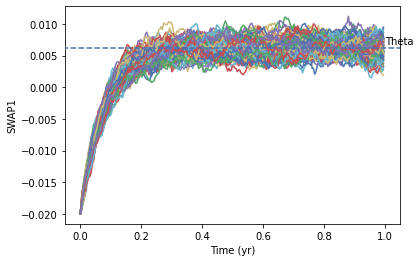

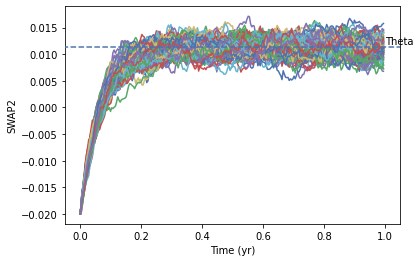

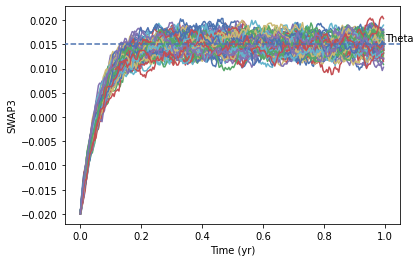

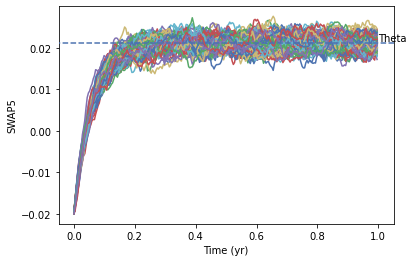

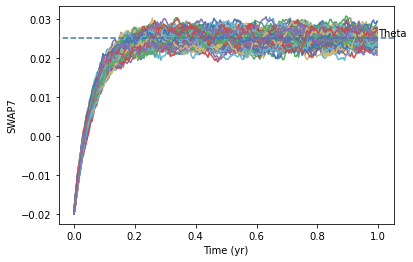

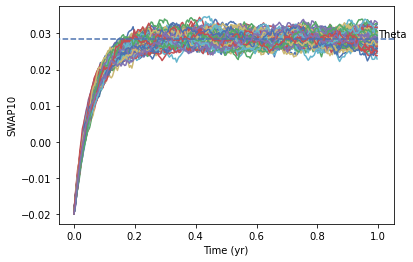

In [133]:
 for i in swp_cols:
   params = Calibration(swap_df.loc[:, i].dropna()/100)
   kappa = params[0]
   theta = params[1]
   sigma = params[2]


   years = 1
   N = years * 252
   t = np.arange(0,N)/252
   M = 100
   rates_arr = MultiSim(M, N, -0.02, kappa*50, theta, sigma)
   plt.plot(t,rates_arr)
   plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
   plt.annotate('Theta', xy=(1.0, theta+0.0005))
   plt.xlim(-0.05, 1.05)

   plt.ylabel(i)
   plt.xlabel("Time (yr)")
   plt.show()

#### For Treasury Data

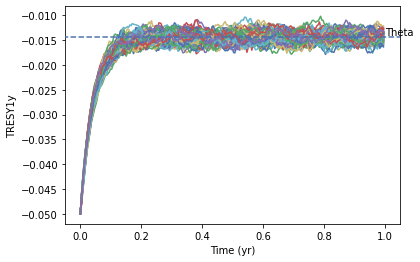

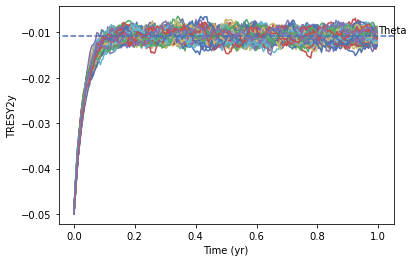

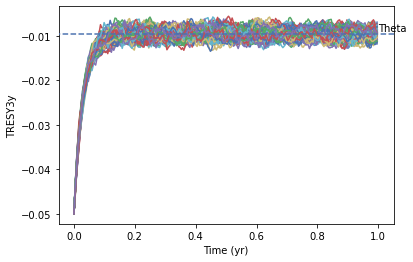

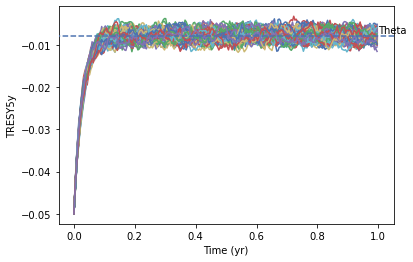

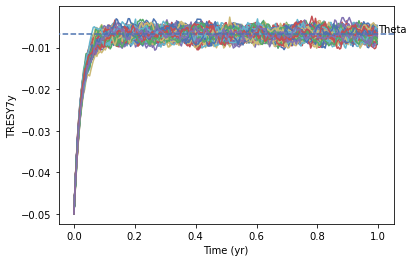

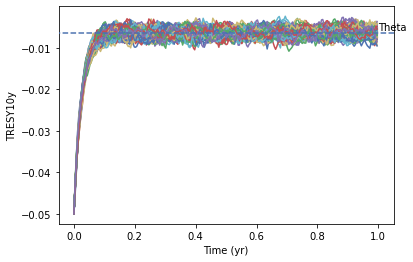

In [134]:
 for i in tres_cols:
   params = Calibration(treasury_df2.loc[:, i].dropna()/100)
   kappa = params[0]
   theta = params[1]
   sigma = params[2]


   years = 1
   N = years * 252
   t = np.arange(0,N)/252
   M = 100
   rates_arr = MultiSim(M, N, -0.05, kappa*100, theta, sigma)
   plt.plot(t,rates_arr)
   plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
   plt.annotate('Theta', xy=(1.0, theta+0.0005))
   plt.xlim(-0.05, 1.05)

   plt.ylabel(i)
   plt.xlabel("Time (yr)")
   plt.show()

#### For Spread Data

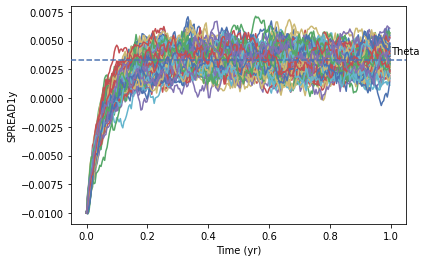

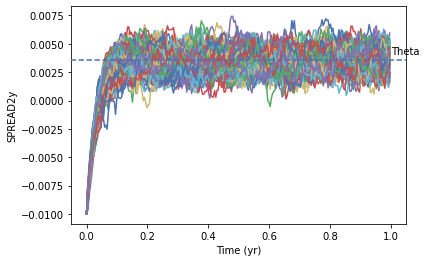

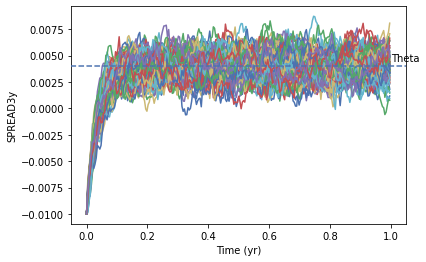

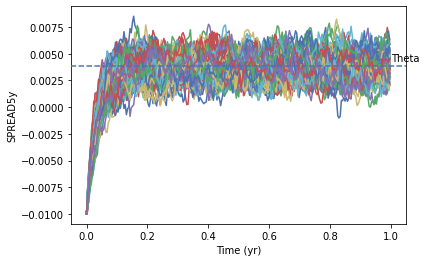

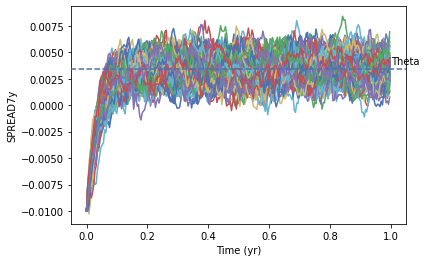

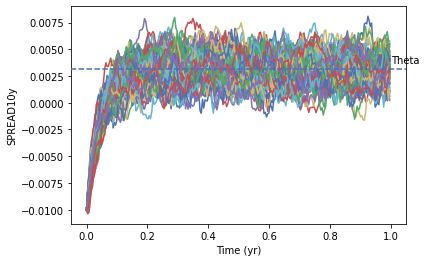

In [135]:
 for i in spr_cols:
   params = Calibration(spread_df.loc[:, i].dropna()/100)
   kappa = params[0]
   theta = params[1]
   sigma = params[2]


   years = 1
   N = years * 252
   t = np.arange(0,N)/252
   M = 100
   rates_arr = MultiSim(M, N, -0.01, kappa*5, theta, sigma)
   plt.plot(t,rates_arr)
   plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
   plt.annotate('Theta', xy=(1.0, theta+0.0005))
   plt.xlim(-0.05, 1.05)

   plt.ylabel(i)
   plt.xlabel("Time (yr)")
   plt.show()